In [1]:
import glob

import os
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import xarray as xr
from functools import lru_cache
import math
import copy
from pathlib import Path
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from netCDF4 import Dataset
import scipy
import climpred

In [2]:
# Load Diffusion Ensemble Data
diff1 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/completed/diffusion_ensemble.nc').day3_IVT
diff2 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/completed/diffusion_ensemble.nc').day4_IVT
diff3 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/completed/diffusion_ensemble.nc').day5_IVT
Num_Forecasts = diff1.shape[1]
#diff_total = xr.concat([diff1,diff2,diff3],dim='time')

/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
unsupported operand type(s) for |: 'type' and 'NoneType'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
#Load West-WRF and ERA5 data
dataX1 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_72/test.nc').forecast[:Num_Forecasts,:,:]
dataX2 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_96/test.nc').forecast[:Num_Forecasts,:,:]
dataX3 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_120/test.nc').forecast[:Num_Forecasts,:,:]
#dataXall = np.concatenate([dataX1,dataX2,dataX3],axis=0)

era1 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_72/test.nc').analysis[:Num_Forecasts,:,:]
era2 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_96/test.nc').analysis[:Num_Forecasts,:,:]
era3 = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_120/test.nc').analysis[:Num_Forecasts,:,:]
#eraall = np.concatenate([era1,era2,era3],axis=0)

## Figure 1

/glade/derecho/scratch/timothyh/tmp/ipykernel_9031/3245202834.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('BrBG')


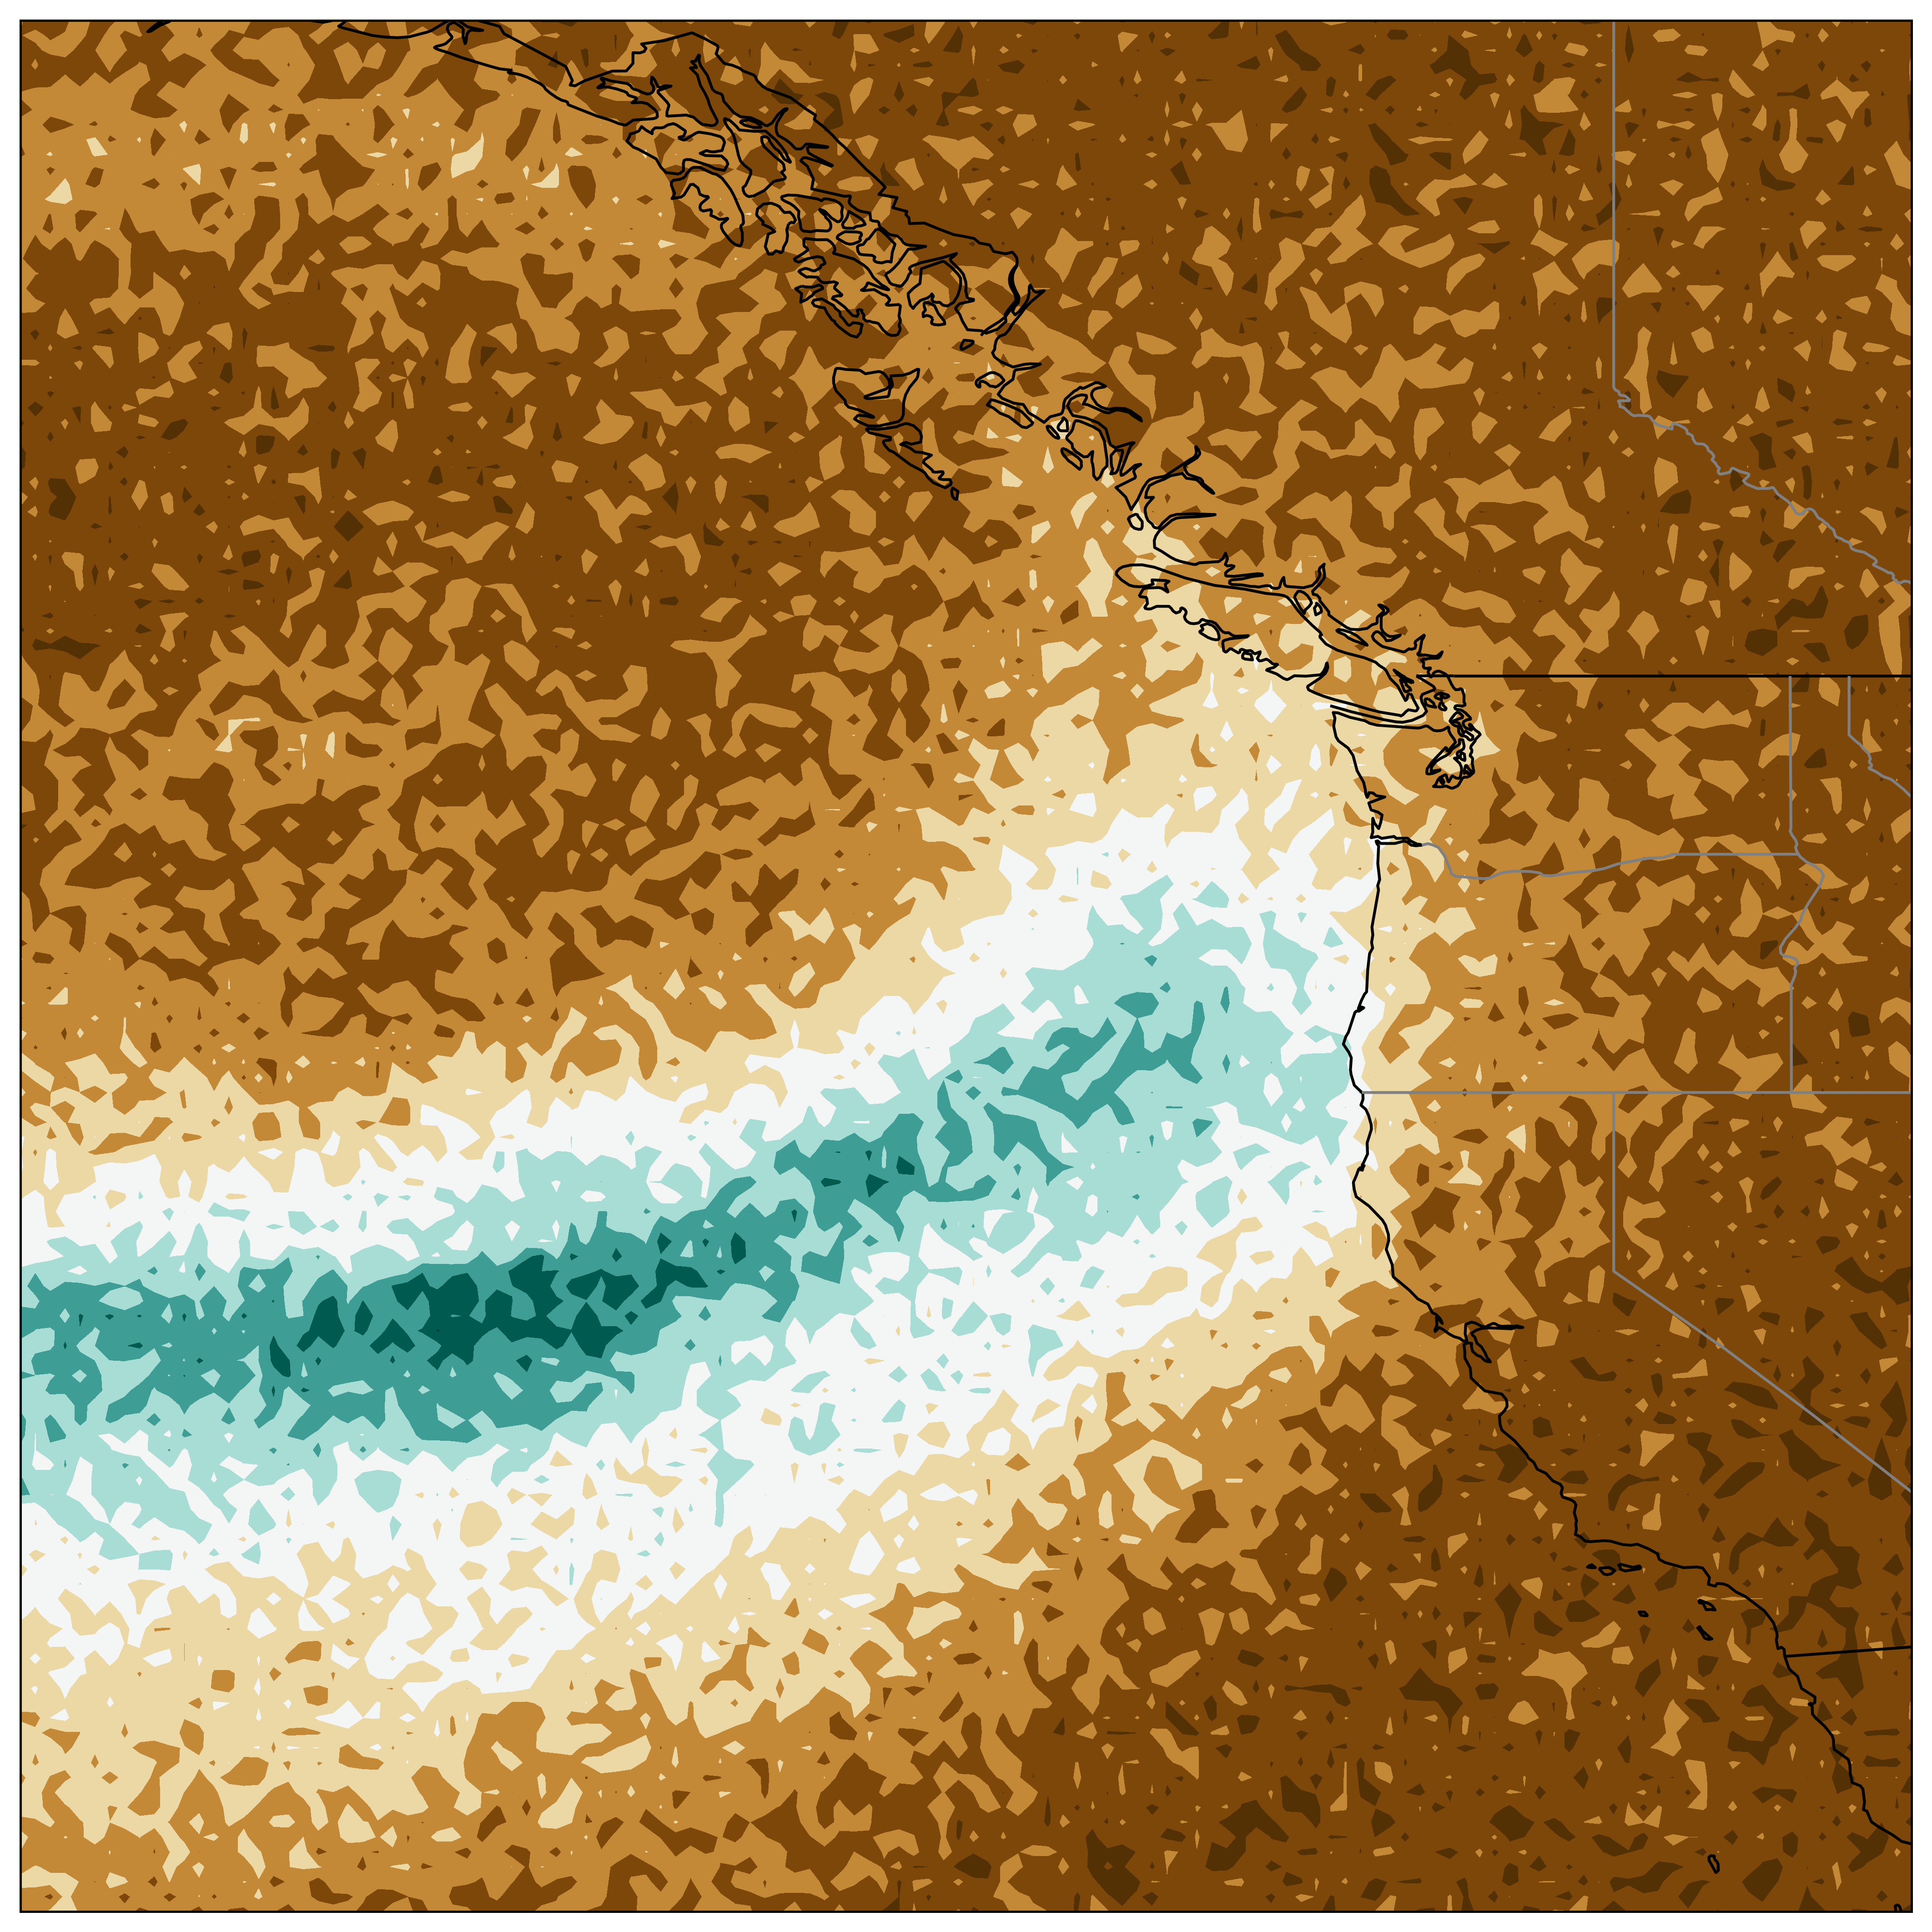

In [3]:
# Only example fields of IVT are necessary
conlevels = np.linspace(0,.3,num=21) #adjust contours 

colormap = plt.cm.get_cmap('BrBG') 
lat = Dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/preprocessed/lead_0/train/F000_WY_1985_500mb.nc').variables['lat'][13:]
lon = Dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/preprocessed/lead_0/train/F000_WY_1985_500mb.nc').variables['lon'][13:]
figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude= -102.5,globe=None))
image = diff3[1,1,:,:]
noise = (450*(np.random.rand(128,128)-.35))
plt.contourf(lon,lat,image+noise,#conlevels,
			transform=ccrs.PlateCarree(),extend = 'both', cmap = colormap)


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
		scale='50m',
		facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(states_provinces, edgecolor='gray')

## Figure 2

/glade/derecho/scratch/timothyh/tmp/ipykernel_9031/2228623177.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('RdBu')


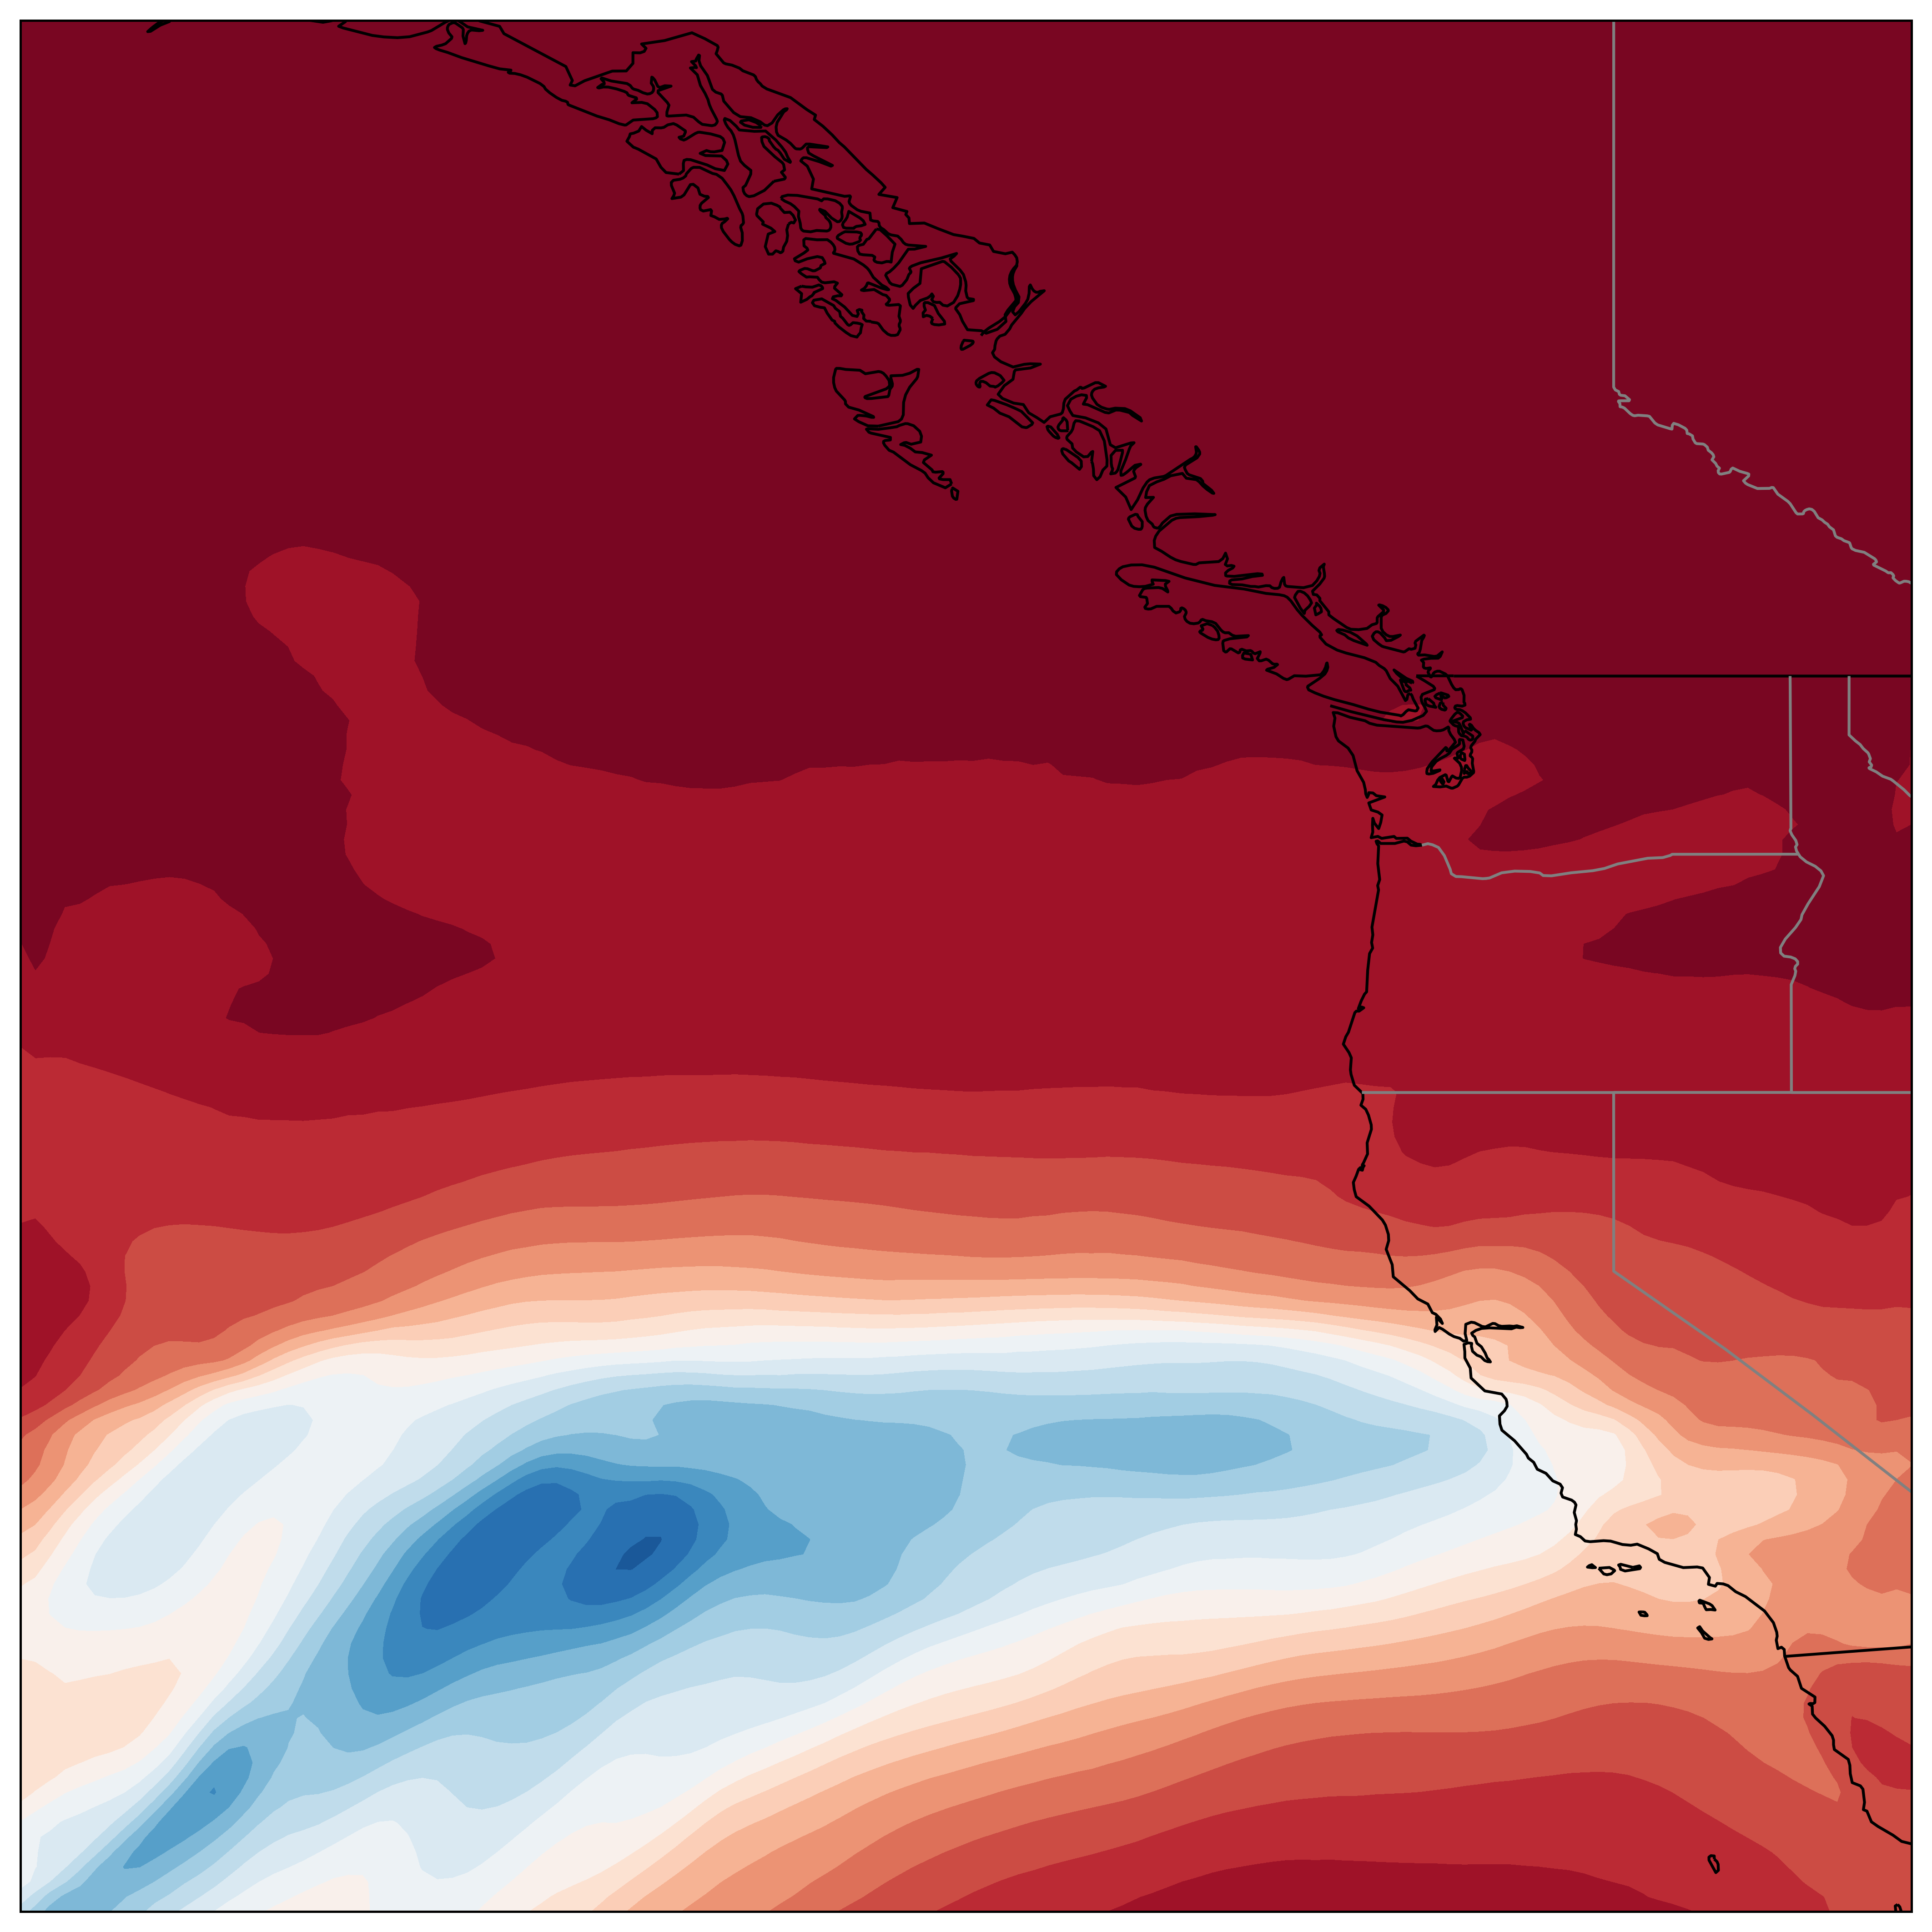

In [12]:
conlevels = np.linspace(0,1500,num=21) #adjust contours 

colormap = plt.cm.get_cmap('RdBu') 

figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude= -102.5,globe=None))
plt.contourf(lon,lat,diff3[24,180,:,:],conlevels,
			transform=ccrs.PlateCarree(),extend = 'both', cmap = colormap)


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
		scale='50m',
		facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='gray')


## Figure 3

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


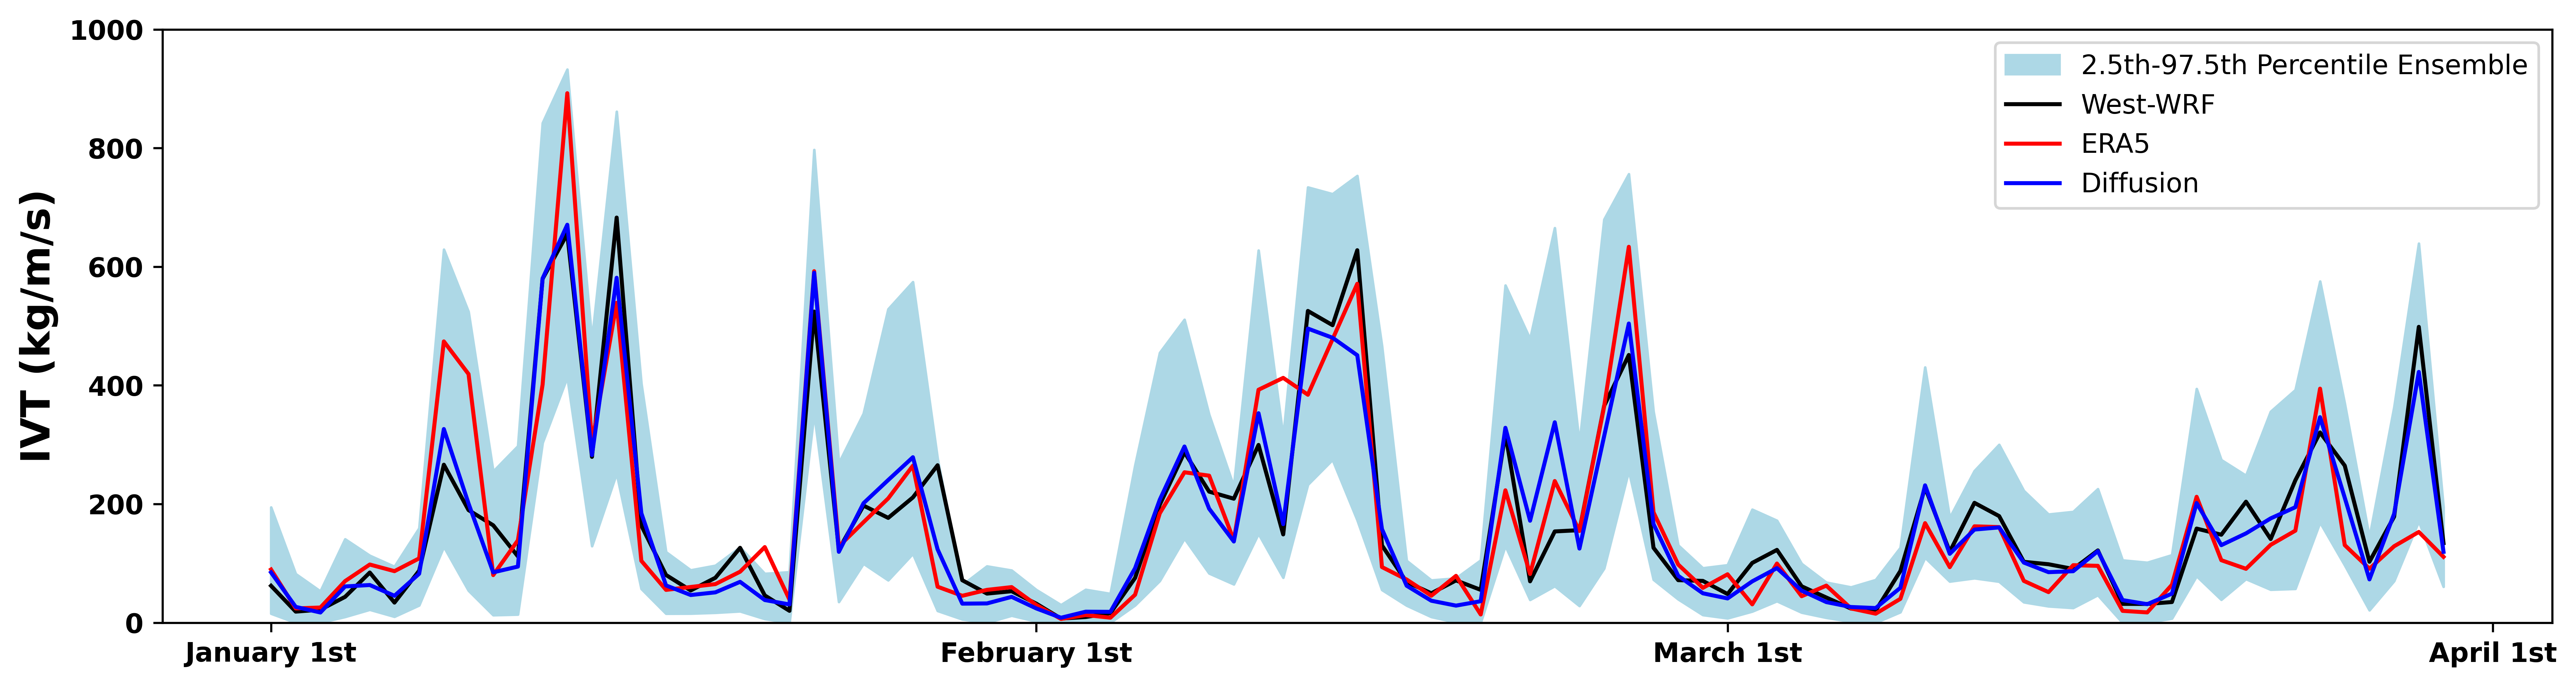

In [7]:
#Must repeat for days 3, 4, and 5

figure(num=None, figsize=(16, 4), dpi=600, facecolor='w', edgecolor='k')
x = np.arange(89)
y = dataX1[143:232,37,98]
eray = era1[143:232,37,98]
diffymean = np.mean(diff1[:,143:232,37,98],axis=0)
diffylow1 = np.percentile(diff1[:,143:232,37,98],2.5,axis=0)
diffyhigh1 = np.percentile(diff1[:,143:232,37,98],97.5,axis=0)

plt.fill_between(x[:],diffylow1,diffyhigh1,color='lightblue',label='2.5th-97.5th Percentile Ensemble')
plt.plot(x,y,color='black',label='West-WRF')
plt.plot(x,eray,color='red',label='ERA5')
plt.plot(x,diffymean,color='blue',label='Diffusion')
plt.xticks(ticks = [0,31,59,90],labels=['January 1st','February 1st','March 1st','April 1st'],weight = 'bold',size = 10)
plt.yticks(weight='bold',size = 10)
plt.ylim([0,1000])

plt.ylabel('IVT (kg/m/s)',weight='bold',size=15)

plt.legend()

## Figure 4

computing ranks
(1001, 5701632)
computing ties


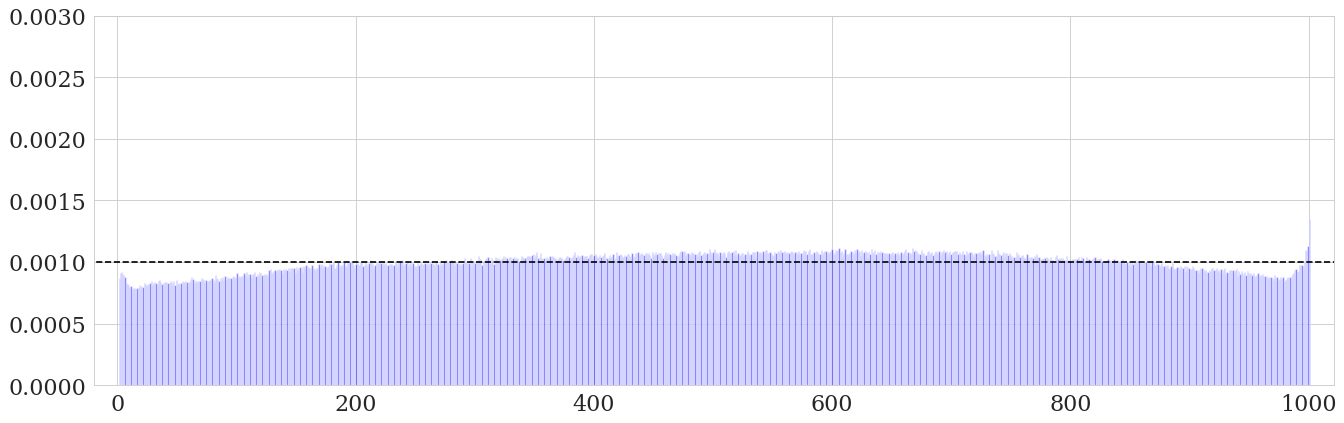

In [4]:
#Must repeat for days 3, 4, and 5
import utils_verif
#import seaborn as sns

ense = 1001
bins = ense # one less because we remove an ensemble... 
fcast='F072'
Thresher=0
datay = era1[:348,:,:]

bounds = [0,5000]
Forecast_ense =  np.reshape(diff1[:,:,:,:],[1000,348*128*128])
m_All = np.mean(Forecast_ense,axis=0)
Obs = np.reshape(np.array(datay[:,:,:]),[348*128*128])
#print("reshaped")
rr2 = utils_verif.ranker(Obs[:],Forecast_ense[:])
    


#print('making figure... takes FOREVER')
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(rr2,bins=bins,density = True,stacked=True,alpha=0.5,label=['0-250','250-500','500+'],color='blue')
plt.plot([-100,1110],[1/(ense-1),1/(ense-1)],'k--')
#plt.legend(fontsize=20)
plt.ylim([0,0.003])
plt.xlim([-20,bins+20])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
#plt.title('mod_num='+str(model_num)+' rmse='+str(np.mean(rmse)))

#plt.savefig(str(model_num)+'.png',bbox_inches='tight')
plt.show()


## Figure 5

In [4]:
#Must repeat for days 3, 4, and 5
era_path = '/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_72/test.nc'
ec_path = '/glade/derecho/scratch/timothyh/data/ECMWF_Forecasts/IVT/day3.nc'
gefs_path = '/glade/derecho/scratch/timothyh/data/GEFS_Forecasts/IVT/day3.nc'
era = xr.open_dataset(era_path).analysis[:Num_Forecasts,:,:]
era_05 = era.isel(lon=slice(1, None, 2), lat=slice(1, None, 2))
# 13 dates for GEFS and 3 dates for ECMWF forecasts were missing. We omitted those forecasts.
missing_gefs = [2,3,4,6,9,10,12,14,15,16,17,18,129,240,243]
missing_ec = [249,338,347]
ec = xr.open_dataset(ec_path).IVT[:,:(Num_Forecasts-len(missing_ec)),:,:]
gefs = xr.open_dataset(gefs_path).IVT[:,:(Num_Forecasts-len(missing_gefs)),:,:]

era_05 = np.flip(era_05,axis=1).assign_coords(lat = gefs.lat, lon = gefs.lon)
# 13 dates for GEFS and 3 dates for ECMWF forecasts were missing. We omitted those forecasts.

GEFS_era_idx = np.delete(np.arange(Num_Forecasts),missing_gefs)
EC_era_idx = np.delete(np.arange(Num_Forecasts),missing_ec)
era_05_gefs = era_05[GEFS_era_idx,:,:].assign_coords(time = gefs.time)

era_05_ec = era_05[EC_era_idx,:,:].assign_coords(time = ec.time)

Num_samples_gefs = gefs.shape[1]
Nbs = 1000
P_Bootstrap_gefs = np.zeros([Nbs])
crps = climpred.metrics._crps(gefs[:,:,:,:], era_05_gefs[:,:,:], dim=['member'])

idxtotal = np.arange(Num_samples_gefs)
for i in range(Nbs):
    idx = np.random.choice(idxtotal,Num_samples_gefs,replace=True)
    crps_Boot = crps[idx,:,:]
    P_Bootstrap_gefs[i] = np.mean(crps_Boot)

Num_samples_ec = ec.shape[1]
P_Bootstrap_ec = np.zeros([Nbs])
crps = climpred.metrics._crps(ec[:,:,:,:], era_05_ec[:,:,:], dim=['member'])
idxtotal = np.arange(Num_samples_ec)
for i in range(Nbs):
    idx = np.random.choice(idxtotal,Num_samples_ec,replace=True)
    crps_Boot = crps[idx,:,:]
    P_Bootstrap_ec[i] = np.mean(crps_Boot)
gefsBootstrapday3 = P_Bootstrap_gefs
ecBootstrapday3 = P_Bootstrap_ec

In [5]:
# Use CRPS_Bootstrapping.py to run bootstrapping for the diffusion ensemble output
Bootstrapday3 = Dataset("/glade/derecho/scratch/timothyh/data/diffusion_forecasts/bootstrapping/DiffusionDay3.nc").variables['__xarray_dataarray_variable__'][:]
Bootstrapday4 = Dataset("/glade/derecho/scratch/timothyh/data/diffusion_forecasts/bootstrapping/DiffusionDay4.nc").variables['__xarray_dataarray_variable__'][:]
Bootstrapday5 = Dataset("/glade/derecho/scratch/timothyh/data/diffusion_forecasts/bootstrapping/DiffusionDay5.nc").variables['__xarray_dataarray_variable__'][:]

<ipython-input-5-c1e1bbb5375b>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Bootstrapday3 = Dataset("/glade/derecho/scratch/timothyh/data/diffusion_forecasts/bootstrapping/DiffusionDay3.nc").variables['__xarray_dataarray_variable__'][:]
<ipython-input-5-c1e1bbb5375b>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Bootstrapday4 = Dataset("/gla

In [27]:
Diffusionerrorbars = np.zeros([2,3])
CRPS = [np.mean(Bootstrapday3),np.mean(Bootstrapday4),np.mean(Bootstrapday5)]

Diffusionerrorbars[0,0] = np.percentile(Bootstrapday3[:],2.5)
Diffusionerrorbars[1,0] = np.percentile(Bootstrapday3[:],97.5)

Diffusionerrorbars[0,1] = np.percentile(Bootstrapday4[:],2.5)
Diffusionerrorbars[1,1] = np.percentile(Bootstrapday4[:],97.5)

Diffusionerrorbars[0,2] = np.percentile(Bootstrapday5[:],2.5)
Diffusionerrorbars[1,2] = np.percentile(Bootstrapday5[:],97.5)


ecDiffusionerrorbars = np.zeros([2,3])
ecCRPS = [np.mean(ecBootstrapday3),np.mean(ecBootstrapday4),np.mean(ecBootstrapday5)]

ecDiffusionerrorbars[0,0] = np.percentile(ecBootstrapday3[:],2.5)
ecDiffusionerrorbars[1,0] = np.percentile(ecBootstrapday3[:],97.5)

ecDiffusionerrorbars[0,1] = np.percentile(ecBootstrapday4[:],2.5)
ecDiffusionerrorbars[1,1] = np.percentile(ecBootstrapday4[:],97.5)

ecDiffusionerrorbars[0,2] = np.percentile(ecBootstrapday5[:],2.5)
ecDiffusionerrorbars[1,2] = np.percentile(ecBootstrapday5[:],97.5)


gefsDiffusionerrorbars = np.zeros([2,3])
gefsCRPS = [np.mean(gefsBootstrapday3),np.mean(gefsBootstrapday4),np.mean(gefsBootstrapday5)]

gefsDiffusionerrorbars[0,0] = np.percentile(gefsBootstrapday3[:],2.5)
gefsDiffusionerrorbars[1,0] = np.percentile(gefsBootstrapday3[:],97.5)

gefsDiffusionerrorbars[0,1] = np.percentile(gefsBootstrapday4[:],2.5)
gefsDiffusionerrorbars[1,1] = np.percentile(gefsBootstrapday4[:],97.5)

gefsDiffusionerrorbars[0,2] = np.percentile(gefsBootstrapday5[:],2.5)
gefsDiffusionerrorbars[1,2] = np.percentile(gefsBootstrapday5[:],97.5)


/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


(0.0, 80.0)

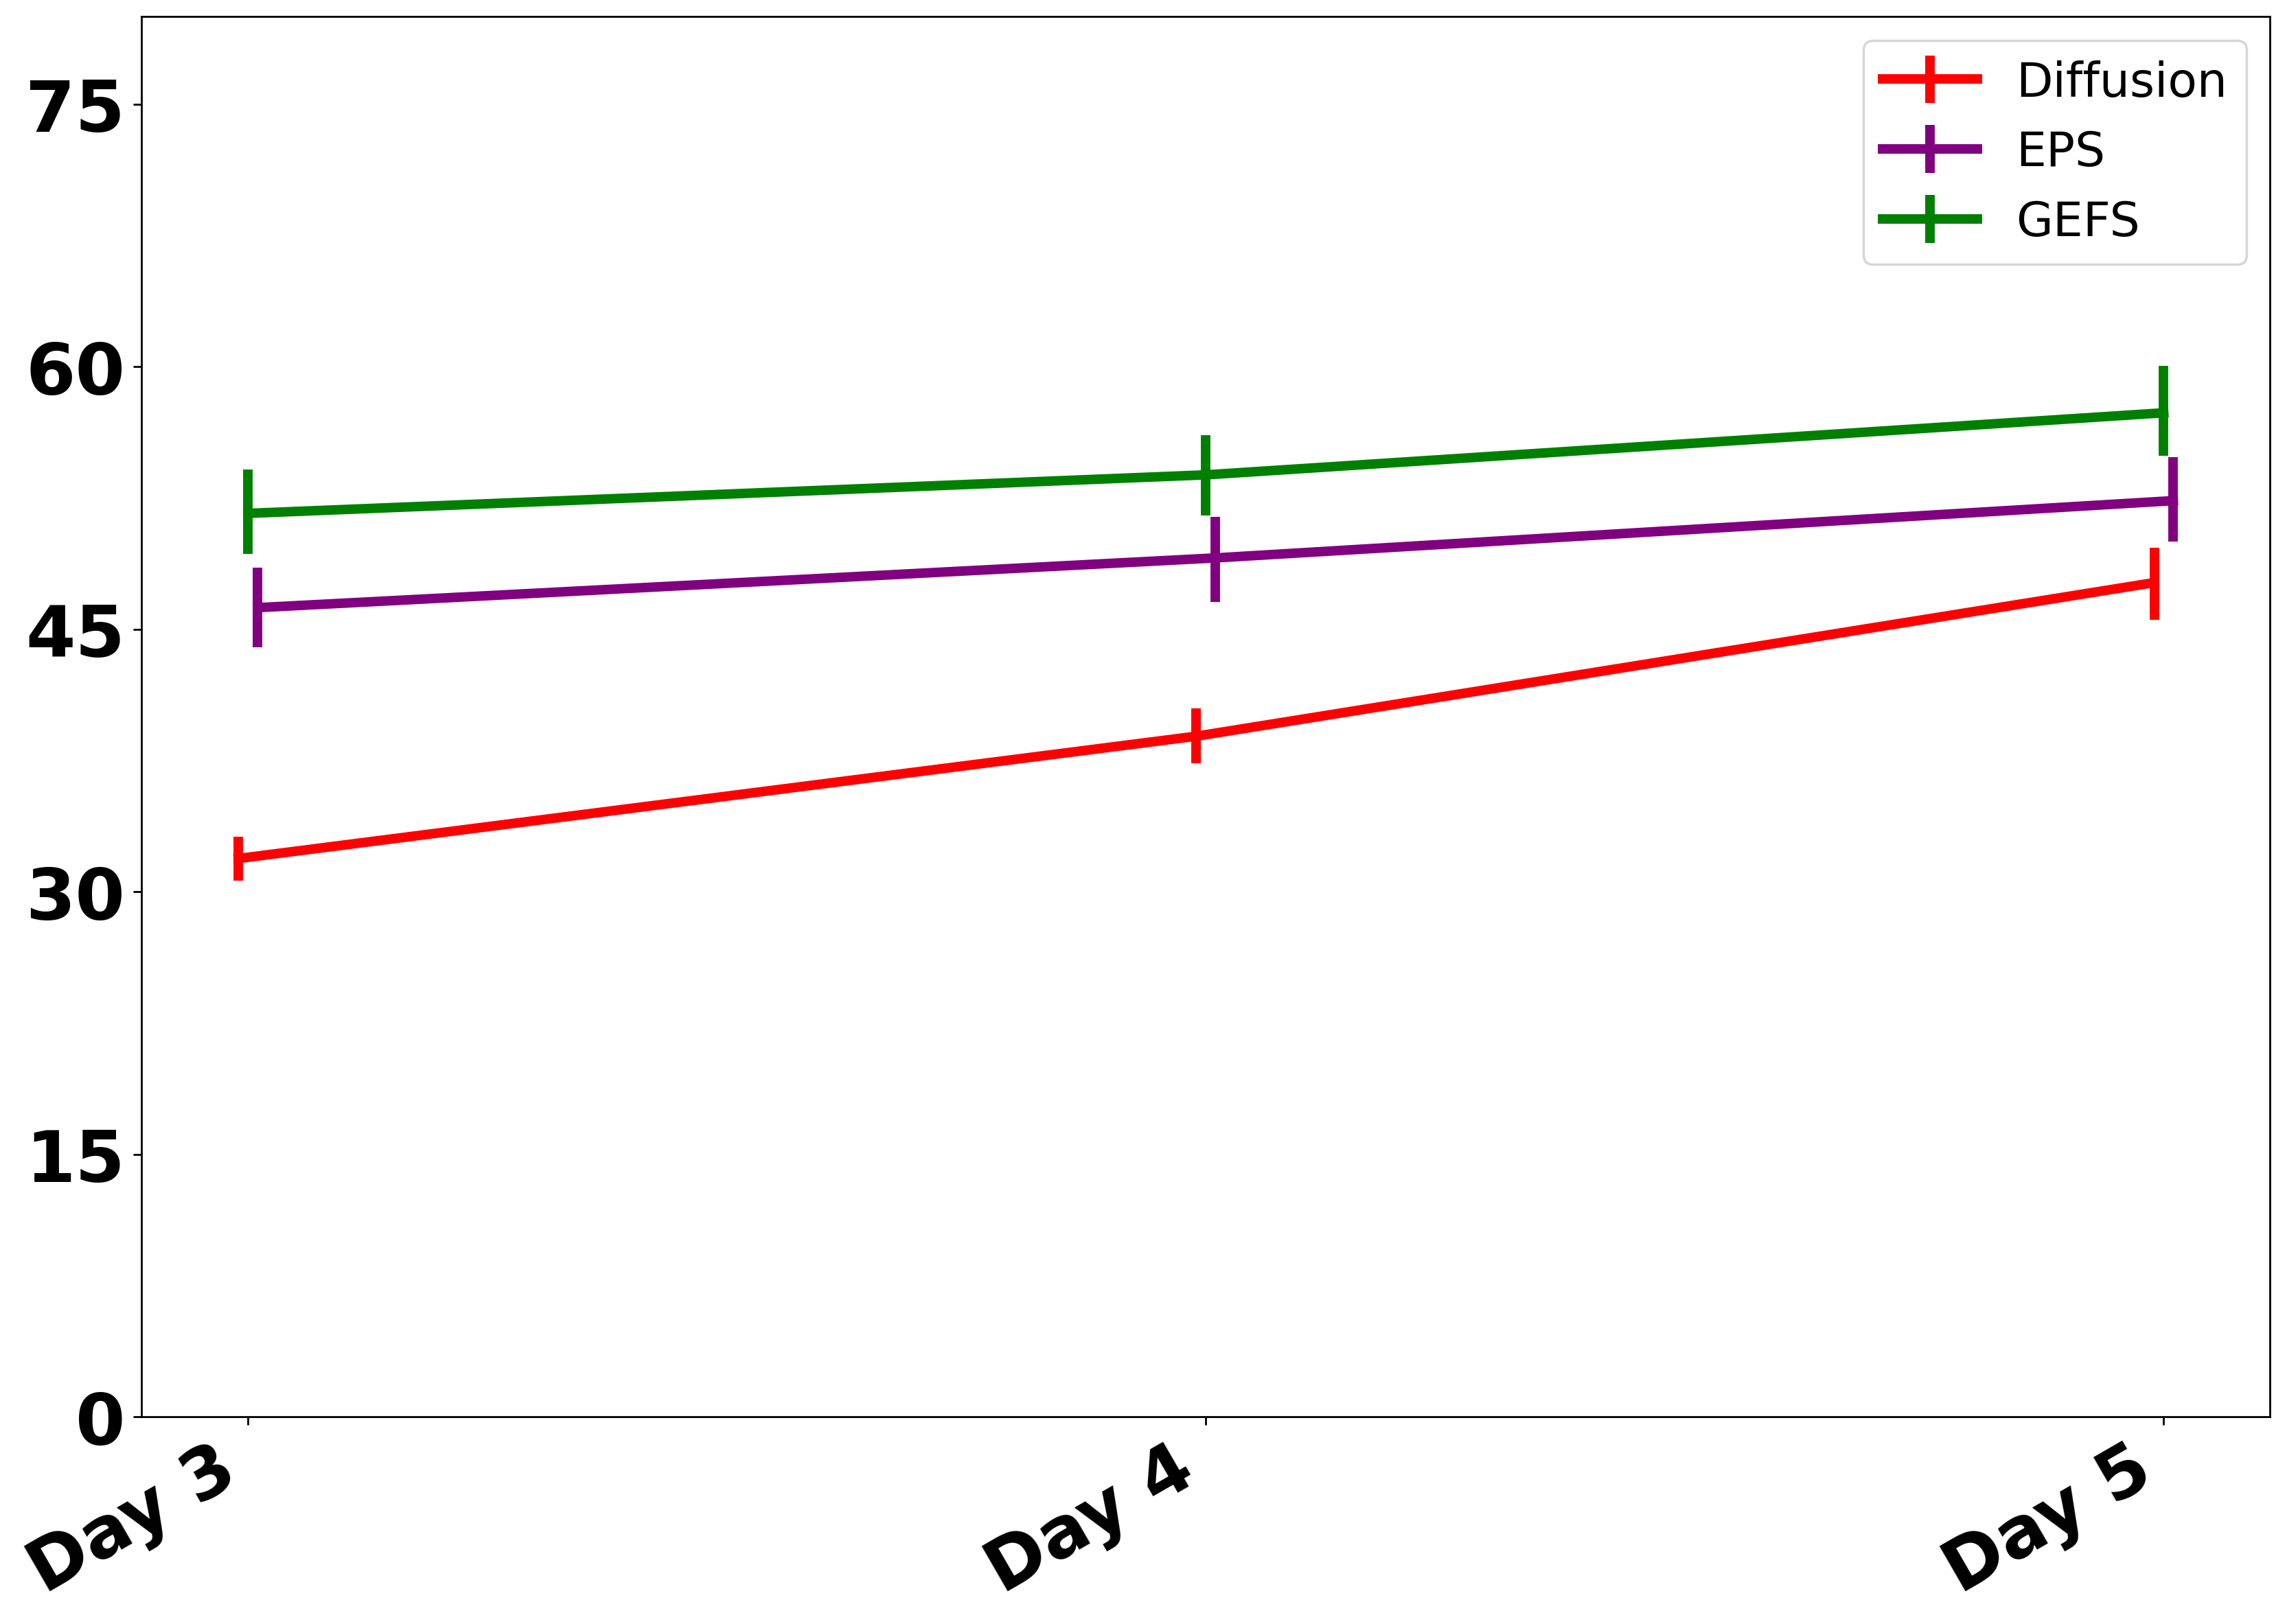

In [28]:
figure(num=None, figsize=(16, 12), dpi=250, facecolor='w', edgecolor='k')

x = np.arange(3)

plt.errorbar(x-.01,CRPS,np.abs(CRPS-Diffusionerrorbars),color='red',label='Diffusion',linewidth = 4)
plt.errorbar(x+.01,ecCRPS,np.abs(ecCRPS-ecDiffusionerrorbars),color='purple',label='EPS',linewidth = 4)
plt.errorbar(x,gefsCRPS,np.abs(gefsCRPS-gefsDiffusionerrorbars),color='green',label='GEFS',linewidth = 4)

#plt.xlim(0,9)
plt.gcf().autofmt_xdate()
plt.legend(prop={'size': 20})
plt.yticks(weight='bold',size = 30,ticks = [0,15,30,45,60,75])
plt.xticks(weight='bold',ticks = [0,1,2],labels=['Day 3','Day 4','Day 5'],size = 30)
plt.ylim([0,80])


## Figure 6

In [10]:
diff_path = '/glade/derecho/scratch/timothyh/data/diffusion_forecasts/completed/Denoised_IVT_day3.nc'
era_path = '/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_72/test.nc'
diff = xr.open_dataset(diff_path).Denoised_IVT[:,:,:,:]
era_diff = xr.open_dataset(era_path).analysis[:Num_Forecasts,:,:]
era_diff = era_diff.assign_coords(lat = diff.lat, lon = diff.lon)
diff = diff.astype(np.float32)
era_diff = era_diff.astype(np.float32)

Simulating data with specified dimensions...
Original ensemble_forecasts_raw_dataset1 shape: (1000, 348, 128, 128)
Original true_values_raw_dataset1 shape: (348, 128, 128)
Original ensemble_forecasts_raw_dataset2 shape: (50, 345, 64, 64)
Original true_values_raw_dataset2 shape: (345, 64, 64)
Reshaped ensemble_forecasts_reshaped_dataset1 shape: (5701632, 1000)
Reshaped true_values_reshaped_dataset1 shape: (5701632,)
Reshaped ensemble_forecasts_reshaped_dataset2 shape: (1413120, 50)
Reshaped true_values_reshaped_dataset2 shape: (1413120,)

Calculating for Dataset 1...
Dataset 1: Number of populated bins: 10

Calculating for Dataset 2...
Dataset 2: Number of populated bins: 10

Calculating for Dataset 3...
Dataset 3: Number of populated bins: 10


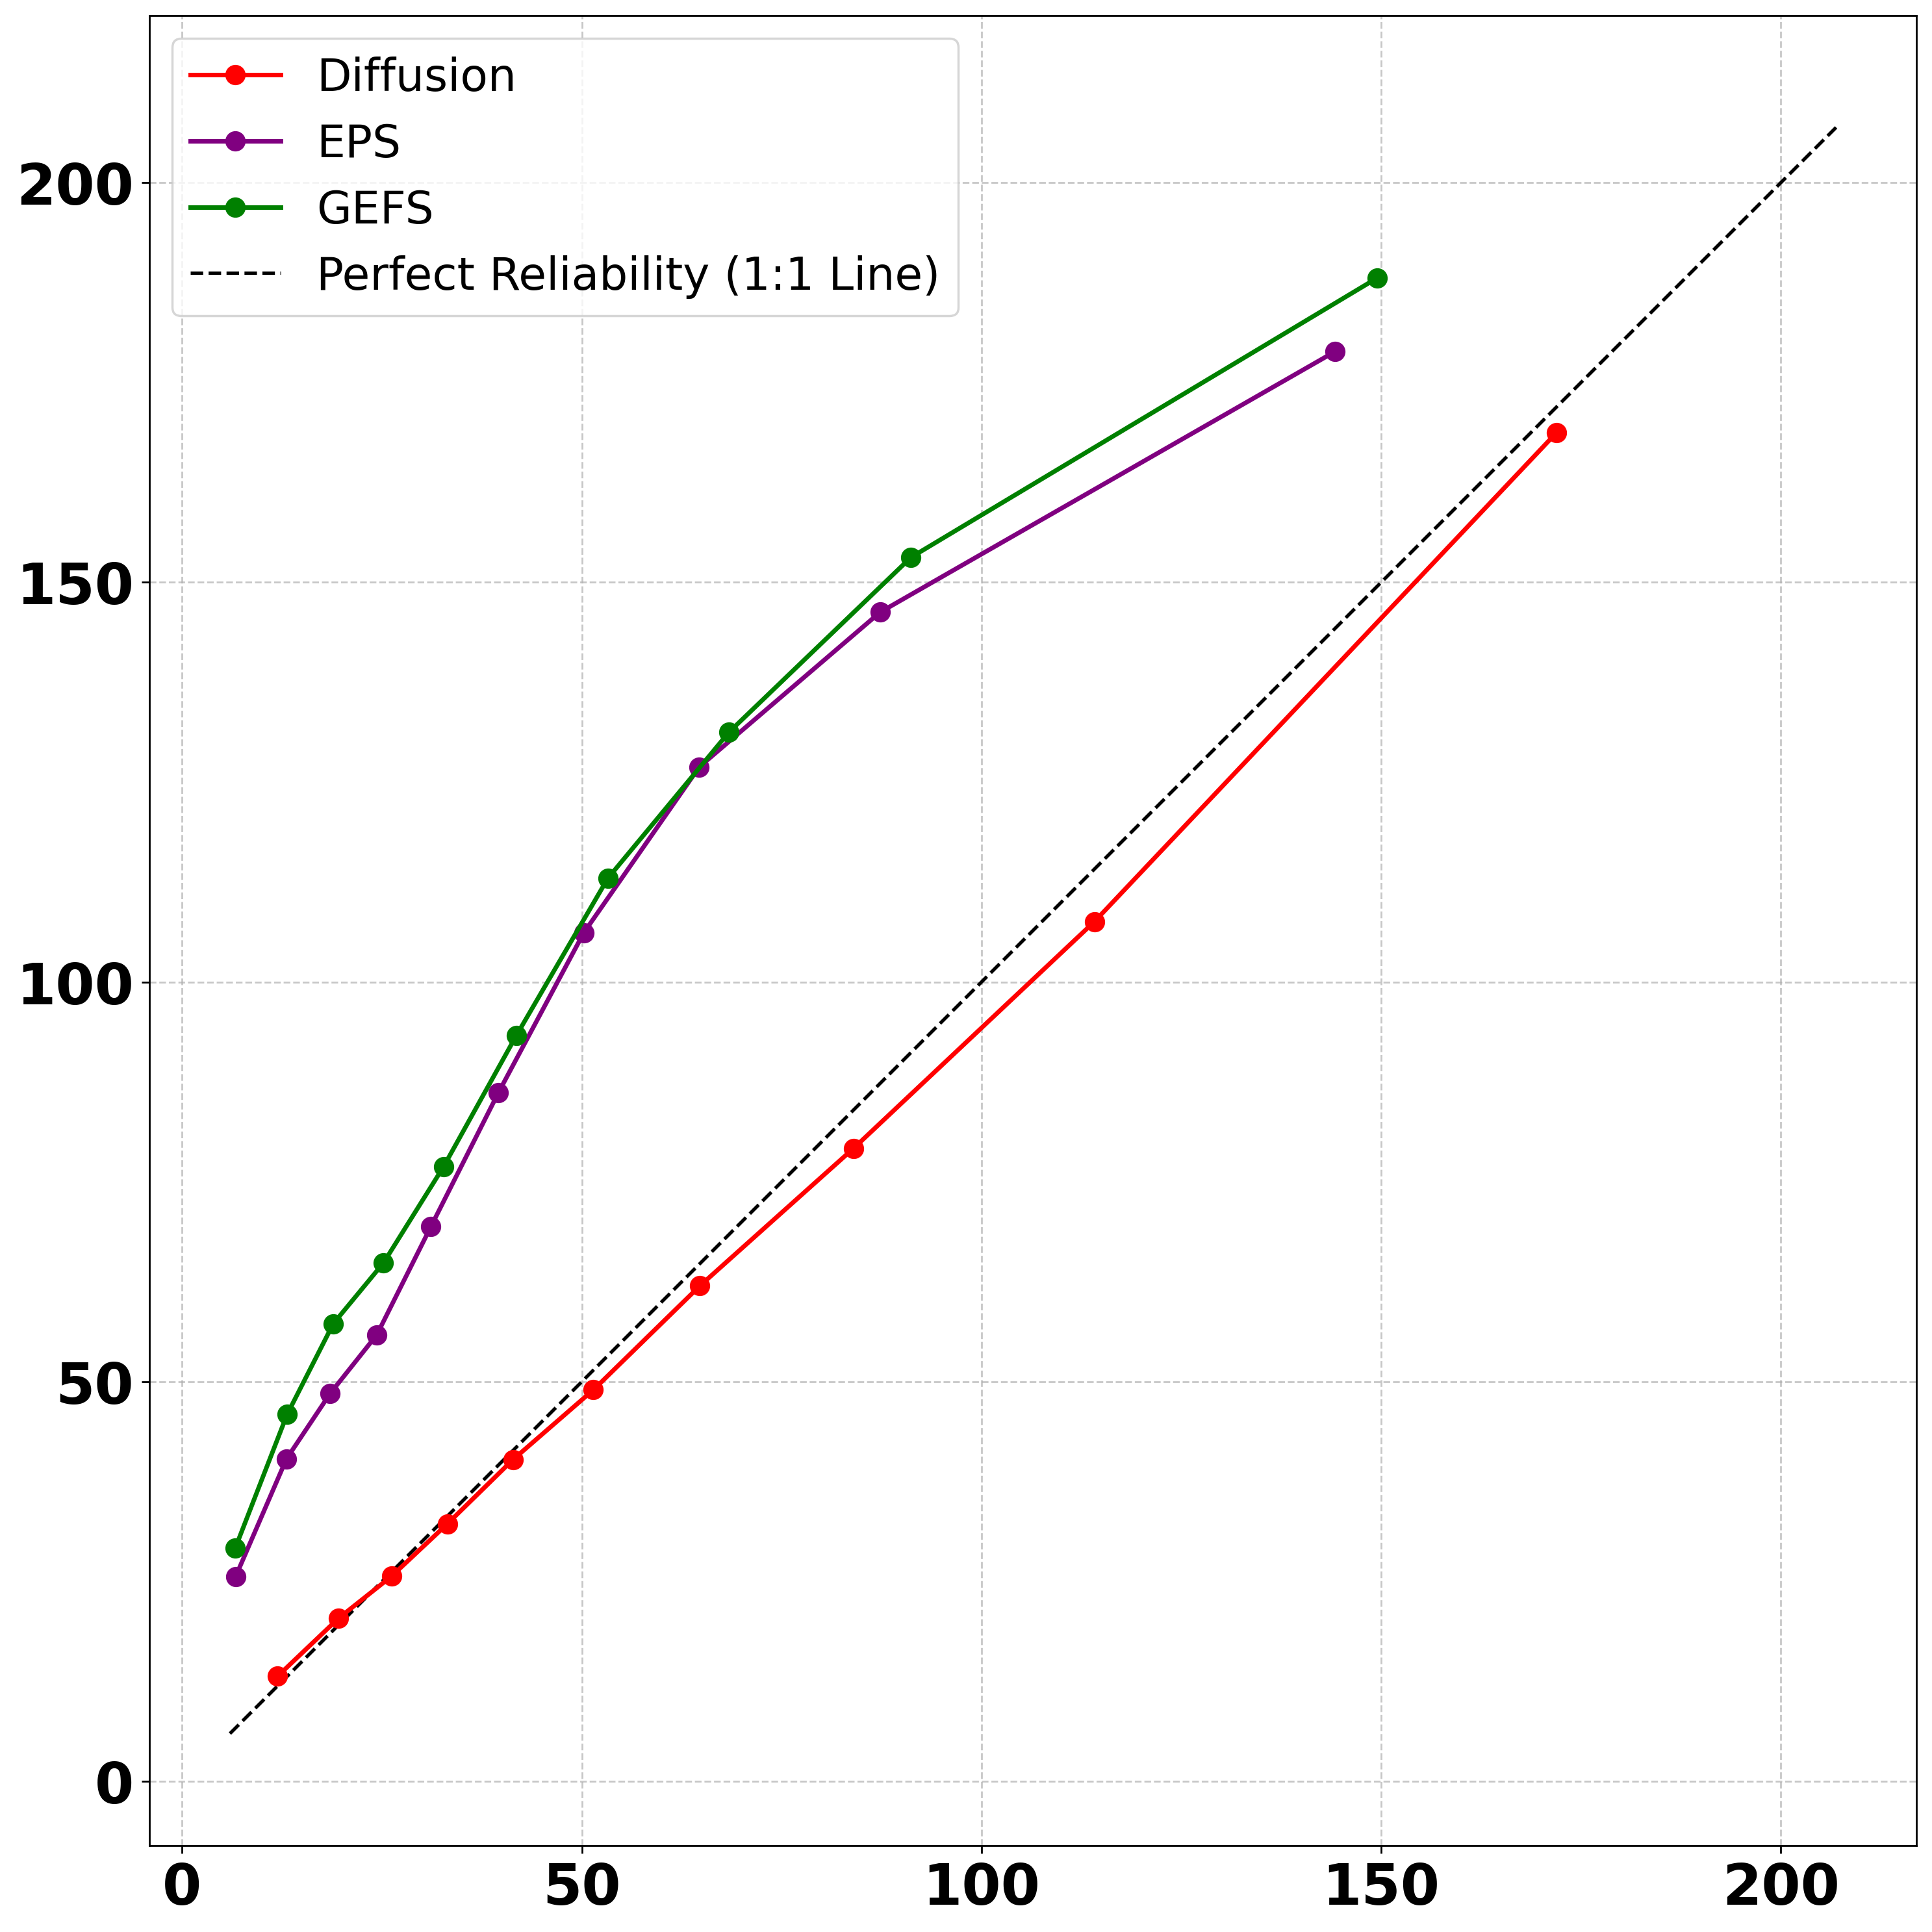

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_binned_spread_rmse(
    true_values_flat, ensemble_forecasts_flat, num_bins=10
):
    """
    Calculates binned ensemble spread vs. RMSE for probabilistic forecasts.
    Bins are created such that each bin contains approximately an equal amount of data points.

    Args:
        true_values_flat (np.ndarray): Flattened array of observed (true) values,
                                       shape (num_cases,).
        ensemble_forecasts_flat (np.ndarray): Flattened 2D array of ensemble forecasts,
                                              shape (num_cases, num_ensemble_members).
        num_bins (int): Desired number of bins. The actual number of populated bins
                        might be less if there are many identical spread values.

    Returns:
        tuple: A tuple containing:
            - binned_spreads (np.ndarray): Average ensemble spread for each bin.
            - binned_rmses (np.ndarray): Average RMSE for each bin.
            - bin_edges (np.ndarray): The edges of the bins used for percentile calculation.
    """
    true_values_flat = np.asarray(true_values_flat)
    ensemble_forecasts_flat = np.asarray(ensemble_forecasts_flat)

    ensemble_mean = np.mean(ensemble_forecasts_flat, axis=1)

    ensemble_spread = np.std(ensemble_forecasts_flat, axis=1)

    squared_errors = (ensemble_mean - true_values_flat)**2

    if np.all(ensemble_spread == ensemble_spread[0]):
        print("Warning: All ensemble spread values are identical. Calculating a single bin.")
        # All data goes into one bin
        binned_spreads = np.array([np.mean(ensemble_spread)])
        binned_rmses = np.array([np.sqrt(np.mean(squared_errors))])
        # Define bin edges as a small range around the single spread value for plotting purposes
        single_spread_value = ensemble_spread[0]
        bin_edges = np.array([single_spread_value - 0.01, single_spread_value + 0.01])
        return binned_spreads, binned_rmses, bin_edges

    percentiles = np.linspace(0, 100, num_bins + 1)
    bin_edges_raw = np.percentile(ensemble_spread, percentiles)


    bin_edges = np.unique(bin_edges_raw)

    if len(bin_edges) < 2:
        min_s = np.min(ensemble_spread)
        max_s = np.max(ensemble_spread)
        # Fallback to a small range if somehow still collapsed after unique
        if min_s == max_s: # This case should ideally be caught by the first all-identical check
             bin_edges = np.array([min_s - 0.01, min_s + 0.01])
        else:
             bin_edges = np.array([min_s, max_s + 1e-9]) # Ensure a proper range for one effective bin.
        print(f"Warning: Adjusted bin edges due to insufficient unique spread values after percentile calculation. Using: {np.round(bin_edges, 2)}")


    binned_spreads = []
    binned_rmses = []

    # 5. Bin the data and calculate average spread and RMSE within each bin
    # Iterate through the actual unique bin edges to define the bins.
    for i in range(len(bin_edges) - 1):
        lower_bound = bin_edges[i]
        upper_bound = bin_edges[i+1]

        # Use inclusive lower bound and exclusive upper bound, except for the last bin's upper bound.
        # This handles cases where spread values might be exactly on a bin edge.
        if i == len(bin_edges) - 2: # This is the last effective bin
            indices_in_bin = np.where((ensemble_spread >= lower_bound) & (ensemble_spread <= upper_bound))[0]
        else:
            indices_in_bin = np.where((ensemble_spread >= lower_bound) & (ensemble_spread < upper_bound))[0]

        if len(indices_in_bin) > 0:
            avg_spread_in_bin = np.mean(ensemble_spread[indices_in_bin])
            binned_spreads.append(avg_spread_in_bin)

            avg_squared_error_in_bin = np.mean(squared_errors[indices_in_bin])
            binned_rmses.append(np.sqrt(avg_squared_error_in_bin))

    return np.array(binned_spreads), np.array(binned_rmses), bin_edges


def plot_binned_spread_rmse(datasets):
    """
    Plots binned ensemble spread vs. RMSE for multiple datasets.

    Args:
        datasets (list of dict): A list where each dictionary contains:
            - 'binned_spreads' (np.ndarray): Average ensemble spread for each bin.
            - 'binned_rmses' (np.ndarray): Average RMSE for each bin.
            - 'label' (str): Label for the dataset in the legend.
            - 'color' (str): Color for the plot line and markers.
        title (str): Title for the plot.
    """
    plt.figure(num=None, figsize=(12, 12), dpi=250, facecolor='w', edgecolor='k')

    all_spreads = []
    all_rmses = []

    for data in datasets:
        binned_spreads = data['binned_spreads']
        binned_rmses = data['binned_rmses']
        label = data['label']
        color = data['color']

        if len(binned_spreads) > 0:
            # Plot the binned data as a line with markers
            plt.plot(binned_spreads, binned_rmses, color=color, marker='o',
                     linestyle='-', linewidth=2, markersize=8, label=label, zorder=5)
            all_spreads.extend(binned_spreads)
            all_rmses.extend(binned_rmses)
        else:
            print(f"Warning: No data points to plot for dataset: {label}")


    # Plot the 1:1 diagonal line for perfect reliability
    # The range for the 1:1 line should cover the range of all spread and RMSE values from all datasets.
    if len(all_spreads) > 0 and len(all_rmses) > 0:
        overall_max_val = max(np.max(all_spreads), np.max(all_rmses)) * 1.1
        overall_min_val = min(np.min(all_spreads), np.min(all_rmses)) * 0.9
        plt.plot([overall_min_val, overall_max_val], [overall_min_val, overall_max_val],
                 color='black', linestyle='--', label='Perfect Reliability (1:1 Line)', zorder=2)
    else:
        # Fallback for plotting 1:1 line if no data is available for any dataset
        plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfect Reliability (1:1 Line)', zorder=2)


    # Add labels and title
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(prop={'size': 20})
    plt.xlim([0,275])
    plt.ylim([0,275])
    plt.xticks(weight='bold',size = 25,ticks = [0,50,100,150,200,250])
    plt.yticks(weight='bold',size = 25,ticks = [0,50,100,150,200,250])
    plt.axis('equal') # Ensure 1:1 aspect ratio
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # --- Simulate or Load Your Data ---
    # Your specified data dimensions:
    num_members = 1000
    num_days = 348
    num_lat = 128
    num_lon = 128

    print("Simulating data with specified dimensions...")

    # --- Dataset 1: Standard Simulation ---
    ensemble_forecasts_raw_dataset1 = np.array(diff)
    true_values_raw_dataset1 = np.array(era_diff)

    # --- Dataset 2: Slightly more under-dispersive (ensemble spread tends to be smaller than error) ---
    # To make it under-dispersive, we can make the ensemble members generally closer to their mean
    # than the true value is to that mean.
    ensemble_forecasts_raw_dataset2 = np.array(ec)
    true_values_raw_dataset2 = np.array(era_05_ec)

    ensemble_forecasts_raw_dataset3 = np.array(gefs)
    true_values_raw_dataset3 = np.array(era_05_gefs)


    print(f"Original ensemble_forecasts_raw_dataset1 shape: {ensemble_forecasts_raw_dataset1.shape}")
    print(f"Original true_values_raw_dataset1 shape: {true_values_raw_dataset1.shape}")
    print(f"Original ensemble_forecasts_raw_dataset2 shape: {ensemble_forecasts_raw_dataset2.shape}")
    print(f"Original true_values_raw_dataset2 shape: {true_values_raw_dataset2.shape}")

    # --- Reshape Data for the Binned Spread-RMSE Calculation ---
    num_forecast_cases = num_days * num_lat * num_lon

    # Reshape Dataset 1
    ensemble_forecasts_reshaped_dataset1 = ensemble_forecasts_raw_dataset1.transpose(1, 2, 3, 0).reshape(
        num_forecast_cases, num_members
    )
    true_values_reshaped_dataset1 = true_values_raw_dataset1.flatten()
    num_lat = 64
    num_lon = 64
    num_forecast_cases = ensemble_forecasts_raw_dataset2.shape[1] * num_lat * num_lon
    num_members = ensemble_forecasts_raw_dataset2.shape[0]
    # Reshape Dataset 2
    ensemble_forecasts_reshaped_dataset2 = ensemble_forecasts_raw_dataset2.transpose(1, 2, 3, 0).reshape(
        num_forecast_cases, num_members
    )
    true_values_reshaped_dataset2 = true_values_raw_dataset2.flatten()

    num_forecast_cases = ensemble_forecasts_raw_dataset3.shape[1] * num_lat * num_lon
    num_members = ensemble_forecasts_raw_dataset3.shape[0]
    # Reshape Dataset 2
    ensemble_forecasts_reshaped_dataset3 = ensemble_forecasts_raw_dataset3.transpose(1, 2, 3, 0).reshape(
        num_forecast_cases, num_members
    )
    true_values_reshaped_dataset3 = true_values_raw_dataset3.flatten()

    print(f"Reshaped ensemble_forecasts_reshaped_dataset1 shape: {ensemble_forecasts_reshaped_dataset1.shape}")
    print(f"Reshaped true_values_reshaped_dataset1 shape: {true_values_reshaped_dataset1.shape}")
    print(f"Reshaped ensemble_forecasts_reshaped_dataset2 shape: {ensemble_forecasts_reshaped_dataset2.shape}")
    print(f"Reshaped true_values_reshaped_dataset2 shape: {true_values_reshaped_dataset2.shape}")

    # --- Calculate and Plot Binned Spread-RMSE ---
    num_bins_for_plot = 10

    print("\nCalculating for Dataset 1...")
    binned_spreads1, binned_rmses1, bin_edges1 = calculate_binned_spread_rmse(
        true_values_reshaped_dataset1, ensemble_forecasts_reshaped_dataset1, num_bins=num_bins_for_plot
    )
    print(f"Dataset 1: Number of populated bins: {len(binned_spreads1)}")

    print("\nCalculating for Dataset 2...")
    binned_spreads2, binned_rmses2, bin_edges2 = calculate_binned_spread_rmse(
        true_values_reshaped_dataset2, ensemble_forecasts_reshaped_dataset2, num_bins=num_bins_for_plot
    )
    print(f"Dataset 2: Number of populated bins: {len(binned_spreads2)}")

    print("\nCalculating for Dataset 3...")
    binned_spreads3, binned_rmses3, bin_edges3 = calculate_binned_spread_rmse(
        true_values_reshaped_dataset3, ensemble_forecasts_reshaped_dataset3, num_bins=num_bins_for_plot
    )
    print(f"Dataset 3: Number of populated bins: {len(binned_spreads3)}")

    # Prepare datasets for plotting
    datasets_to_plot = []
    if len(binned_spreads1) > 0:
        datasets_to_plot.append({
            'binned_spreads': binned_spreads1,
            'binned_rmses': binned_rmses1,
            'label': 'Diffusion',
            'color': 'red'
        })
    if len(binned_spreads2) > 0:
        datasets_to_plot.append({
            'binned_spreads': binned_spreads2,
            'binned_rmses': binned_rmses2,
            'label': 'EPS',
            'color': 'purple'
        })

    if len(binned_spreads3) > 0:
        datasets_to_plot.append({
            'binned_spreads': binned_spreads3,
            'binned_rmses': binned_rmses3,
            'label': 'GEFS',
            'color': 'green'
        })

    # Plot the results
    if len(datasets_to_plot) > 0:
        plot_binned_spread_rmse(
            datasets_to_plot
        )
    else:
        print("\nNo data points in any bin across all datasets to plot. Check your input data or binning parameters.")

## Figure 7

In [10]:
#Must repeat code for days 3, 4, and 5
era_path = '/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_72/test.nc'
ec_path = '/glade/derecho/scratch/timothyh/data/ECMWF_Forecasts/IVT/day3.nc'
gefs_path = '/glade/derecho/scratch/timothyh/data/GEFS_Forecasts/IVT/day3.nc'
era = xr.open_dataset(era_path).analysis[:Num_Forecasts,:,:]
era_05 = era.isel(lon=slice(1, None, 2), lat=slice(1, None, 2))
# 13 dates for GEFS and 3 dates for ECMWF forecasts were missing. We omitted those forecasts.
missing_gefs = [2,3,4,6,9,10,12,14,15,16,17,18,129,240,243]
missing_ec = [249,338,347]

ec = xr.open_dataset(ec_path).IVT[:,:(Num_Forecasts-len(missing_ec)),:,:]
gefs = xr.open_dataset(gefs_path).IVT[:,:(Num_Forecasts-len(missing_gefs)),:,:]
era_05 = np.flip(era_05,axis=1).assign_coords(lat = gefs.lat, lon = gefs.lon)

GEFS_era_idx = np.delete(np.arange(Num_Forecasts),missing_gefs)
EC_era_idx = np.delete(np.arange(Num_Forecasts),missing_ec)
era_05_gefs = era_05[GEFS_era_idx,:,:].assign_coords(time = gefs.time)

era_05_ec = era_05[EC_era_idx,:,:].assign_coords(time = ec.time)
era1 = era1.assign_coords(time = diff1.time,lat = diff1.lat, lon = diff1.lon)
dataX1 = dataX1.assign_coords(time = diff1.time,lat = diff1.lat, lon = diff1.lon)


diff_mean = np.mean(diff1,axis=0)
Num_samples = Num_Forecasts
Nbs = 1000
P_BootstrapWRFRMSE = np.zeros([Nbs])
P_BootstrapDiffusionACC = np.zeros([Nbs])
P_BootstrapDiffusionRMSE = np.zeros([Nbs])
P_BootstrapWRFACC = np.zeros([Nbs])


idxtotal = np.arange(Num_Forecasts)
i = 0
while i < Nbs:
    idx = np.random.choice(idxtotal,Num_samples)
    ACC_diff = climpred.metrics._pearson_r(xr.DataArray(diff_mean[idx,:,:]),era1[idx,:,:],dim=["time"])
    ACC_WRF = climpred.metrics._pearson_r(dataX1[idx,:,:],era1[idx,:,:], dim=["time"])
    P_BootstrapDiffusionACC[i] = np.mean(ACC_diff)
    RMSE_diff = np.sqrt((np.array(diff_mean[idx,:,:])-np.array(era1[idx,:,:]))**2)
    RMSE_WRF = np.sqrt((np.array(dataX1[idx,:,:])-np.array(era1[idx,:,:]))**2)
    P_BootstrapDiffusionRMSE[i] = np.mean(RMSE_diff)
    P_BootstrapWRFRMSE[i] = np.mean(RMSE_WRF)
    P_BootstrapWRFACC[i] = np.mean(ACC_WRF)
    i+=1

In [11]:

Num_samples_gefs = gefs.shape[1]
Nbs = 1000
P_Bootstrap_acc_gefs = np.zeros([Nbs])
P_Bootstrap_rmse_gefs = np.zeros([Nbs])

gefsmean = np.mean(gefs,axis=0)
ecmean = np.mean(ec,axis=0)
idxtotal = np.arange(Num_samples_gefs)
for i in range(Nbs):
    idx = np.random.choice(idxtotal,Num_samples_gefs,replace=True)
    ACC_gefs = climpred.metrics._pearson_r(gefsmean[idx,:,:], era_05_gefs[idx,:,:], dim=['time'])
    P_Bootstrap_acc_gefs[i] = np.mean(ACC_gefs)
    RMSE_gefs = np.sqrt((np.array(gefsmean[idx,:,:])-np.array(era_05_gefs[idx,:,:]))**2)
    P_Bootstrap_rmse_gefs[i] = np.mean(RMSE_gefs)

Num_samples_ec = ec.shape[1]
P_Bootstrap_acc_ec = np.zeros([Nbs])
P_Bootstrap_rmse_ec = np.zeros([Nbs])
idxtotal = np.arange(Num_samples_ec)
for i in range(Nbs):
    idx = np.random.choice(idxtotal,Num_samples_ec,replace=True)
    ACC_ec = climpred.metrics._pearson_r(ecmean[idx,:,:], era_05_ec[idx,:,:], dim=['time'])
    P_Bootstrap_acc_ec[i] = np.mean(ACC_ec)
    RMSE_ec = np.sqrt((np.array(ecmean[idx,:,:])-np.array(era_05_ec[idx,:,:]))**2)
    P_Bootstrap_rmse_ec[i] = np.mean(RMSE_ec)


In [12]:
P_BootstrapDiffusionACCday3 = P_BootstrapDiffusionACC
P_BootstrapDiffusionRMSEday3 = P_BootstrapDiffusionRMSE
P_BootstrapgefsACCday3 = P_Bootstrap_acc_gefs
P_BootstrapgefsRMSEday3 = P_Bootstrap_rmse_gefs
P_BootstrapecACCday3 = P_Bootstrap_acc_ec
P_BootstrapecRMSEday3 = P_Bootstrap_rmse_ec
P_BootstrapWRFACCday3 = P_BootstrapWRFACC
P_BootstrapWRFRMSEday3 = P_BootstrapWRFRMSE


In [25]:
DiffusionACC = np.zeros([3])
DiffusionRMSE = np.zeros([3])
gefsACC = np.zeros([3])
gefsRMSE = np.zeros([3])
ecACC = np.zeros([3])
ecRMSE = np.zeros([3])


DiffusionACC[0] = np.mean(P_BootstrapDiffusionACCday3)
DiffusionACC[1] = np.mean(P_BootstrapDiffusionACCday4)
DiffusionACC[2] = np.mean(P_BootstrapDiffusionACCday5)

gefsACC[0] = np.mean(P_BootstrapgefsACCday3)
gefsACC[1] = np.mean(P_BootstrapgefsACCday4)
gefsACC[2] = np.mean(P_BootstrapgefsACCday5)

ecACC[0] = np.mean(P_BootstrapecACCday3)
ecACC[1] = np.mean(P_BootstrapecACCday4)
ecACC[2] = np.mean(P_BootstrapecACCday5)

gefsRMSE[0] = np.mean(P_BootstrapgefsRMSEday3)
gefsRMSE[1] = np.mean(P_BootstrapgefsRMSEday4)
gefsRMSE[2] = np.mean(P_BootstrapgefsRMSEday5)

ecRMSE[0] = np.mean(P_BootstrapecRMSEday3)
ecRMSE[1] = np.mean(P_BootstrapecRMSEday4)
ecRMSE[2] = np.mean(P_BootstrapecRMSEday5)

WRFACC = np.zeros([3])
WRFACC[0] = np.mean(P_BootstrapWRFACCday3)
WRFACC[1] = np.mean(P_BootstrapWRFACCday4)
WRFACC[2] = np.mean(P_BootstrapWRFACCday5)
DiffusionRMSE[0] = np.mean(P_BootstrapDiffusionRMSEday3)
DiffusionRMSE[1] = np.mean(P_BootstrapDiffusionRMSEday4)
DiffusionRMSE[2] = np.mean(P_BootstrapDiffusionRMSEday5)
WRFRMSE = np.zeros([3])
WRFRMSE[0] = np.mean(P_BootstrapWRFRMSEday3)
WRFRMSE[1] = np.mean(P_BootstrapWRFRMSEday4)
WRFRMSE[2] = np.mean(P_BootstrapWRFRMSEday5)

In [31]:
Diffusionerrorbars = np.zeros([2,3])
gefserrorbars = np.zeros([2,3])
ecerrorbars = np.zeros([2,3])
WRFerrorbars = np.zeros([2,3])


Diffusionerrorbars[0,0] = np.percentile(P_BootstrapDiffusionACCday3,2.5)
Diffusionerrorbars[1,0] = np.percentile(P_BootstrapDiffusionACCday3,97.5)
Diffusionerrorbars[0,1] = np.percentile(P_BootstrapDiffusionACCday4,2.5)
Diffusionerrorbars[1,1] = np.percentile(P_BootstrapDiffusionACCday4,97.5)
Diffusionerrorbars[0,2] = np.percentile(P_BootstrapDiffusionACCday5,2.5)
Diffusionerrorbars[1,2] = np.percentile(P_BootstrapDiffusionACCday5,97.5)

WRFerrorbars[0,0] = np.percentile(P_BootstrapWRFACCday3,2.5)
WRFerrorbars[1,0] = np.percentile(P_BootstrapWRFACCday3,97.5)
WRFerrorbars[0,1] = np.percentile(P_BootstrapWRFACCday4,2.5)
WRFerrorbars[1,1] = np.percentile(P_BootstrapWRFACCday4,97.5)
WRFerrorbars[0,2] = np.percentile(P_BootstrapWRFACCday5,2.5)
WRFerrorbars[1,2] = np.percentile(P_BootstrapWRFACCday5,97.5)

gefserrorbars[0,0] = np.percentile(P_BootstrapgefsACCday3,2.5)
gefserrorbars[1,0] = np.percentile(P_BootstrapgefsACCday3,97.5)
gefserrorbars[0,1] = np.percentile(P_BootstrapgefsACCday4,2.5)
gefserrorbars[1,1] = np.percentile(P_BootstrapgefsACCday4,97.5)
gefserrorbars[0,2] = np.percentile(P_BootstrapgefsACCday5,2.5)
gefserrorbars[1,2] = np.percentile(P_BootstrapgefsACCday5,97.5)

ecerrorbars[0,0] = np.percentile(P_BootstrapecACCday3,2.5)
ecerrorbars[1,0] = np.percentile(P_BootstrapecACCday3,97.5)
ecerrorbars[0,1] = np.percentile(P_BootstrapecACCday4,2.5)
ecerrorbars[1,1] = np.percentile(P_BootstrapecACCday4,97.5)
ecerrorbars[0,2] = np.percentile(P_BootstrapecACCday5,2.5)
ecerrorbars[1,2] = np.percentile(P_BootstrapecACCday5,97.5)

In [24]:
ecRMSE

array([0.75893955, 0.71206442, 0.65247728])

(0.5, 1.0)

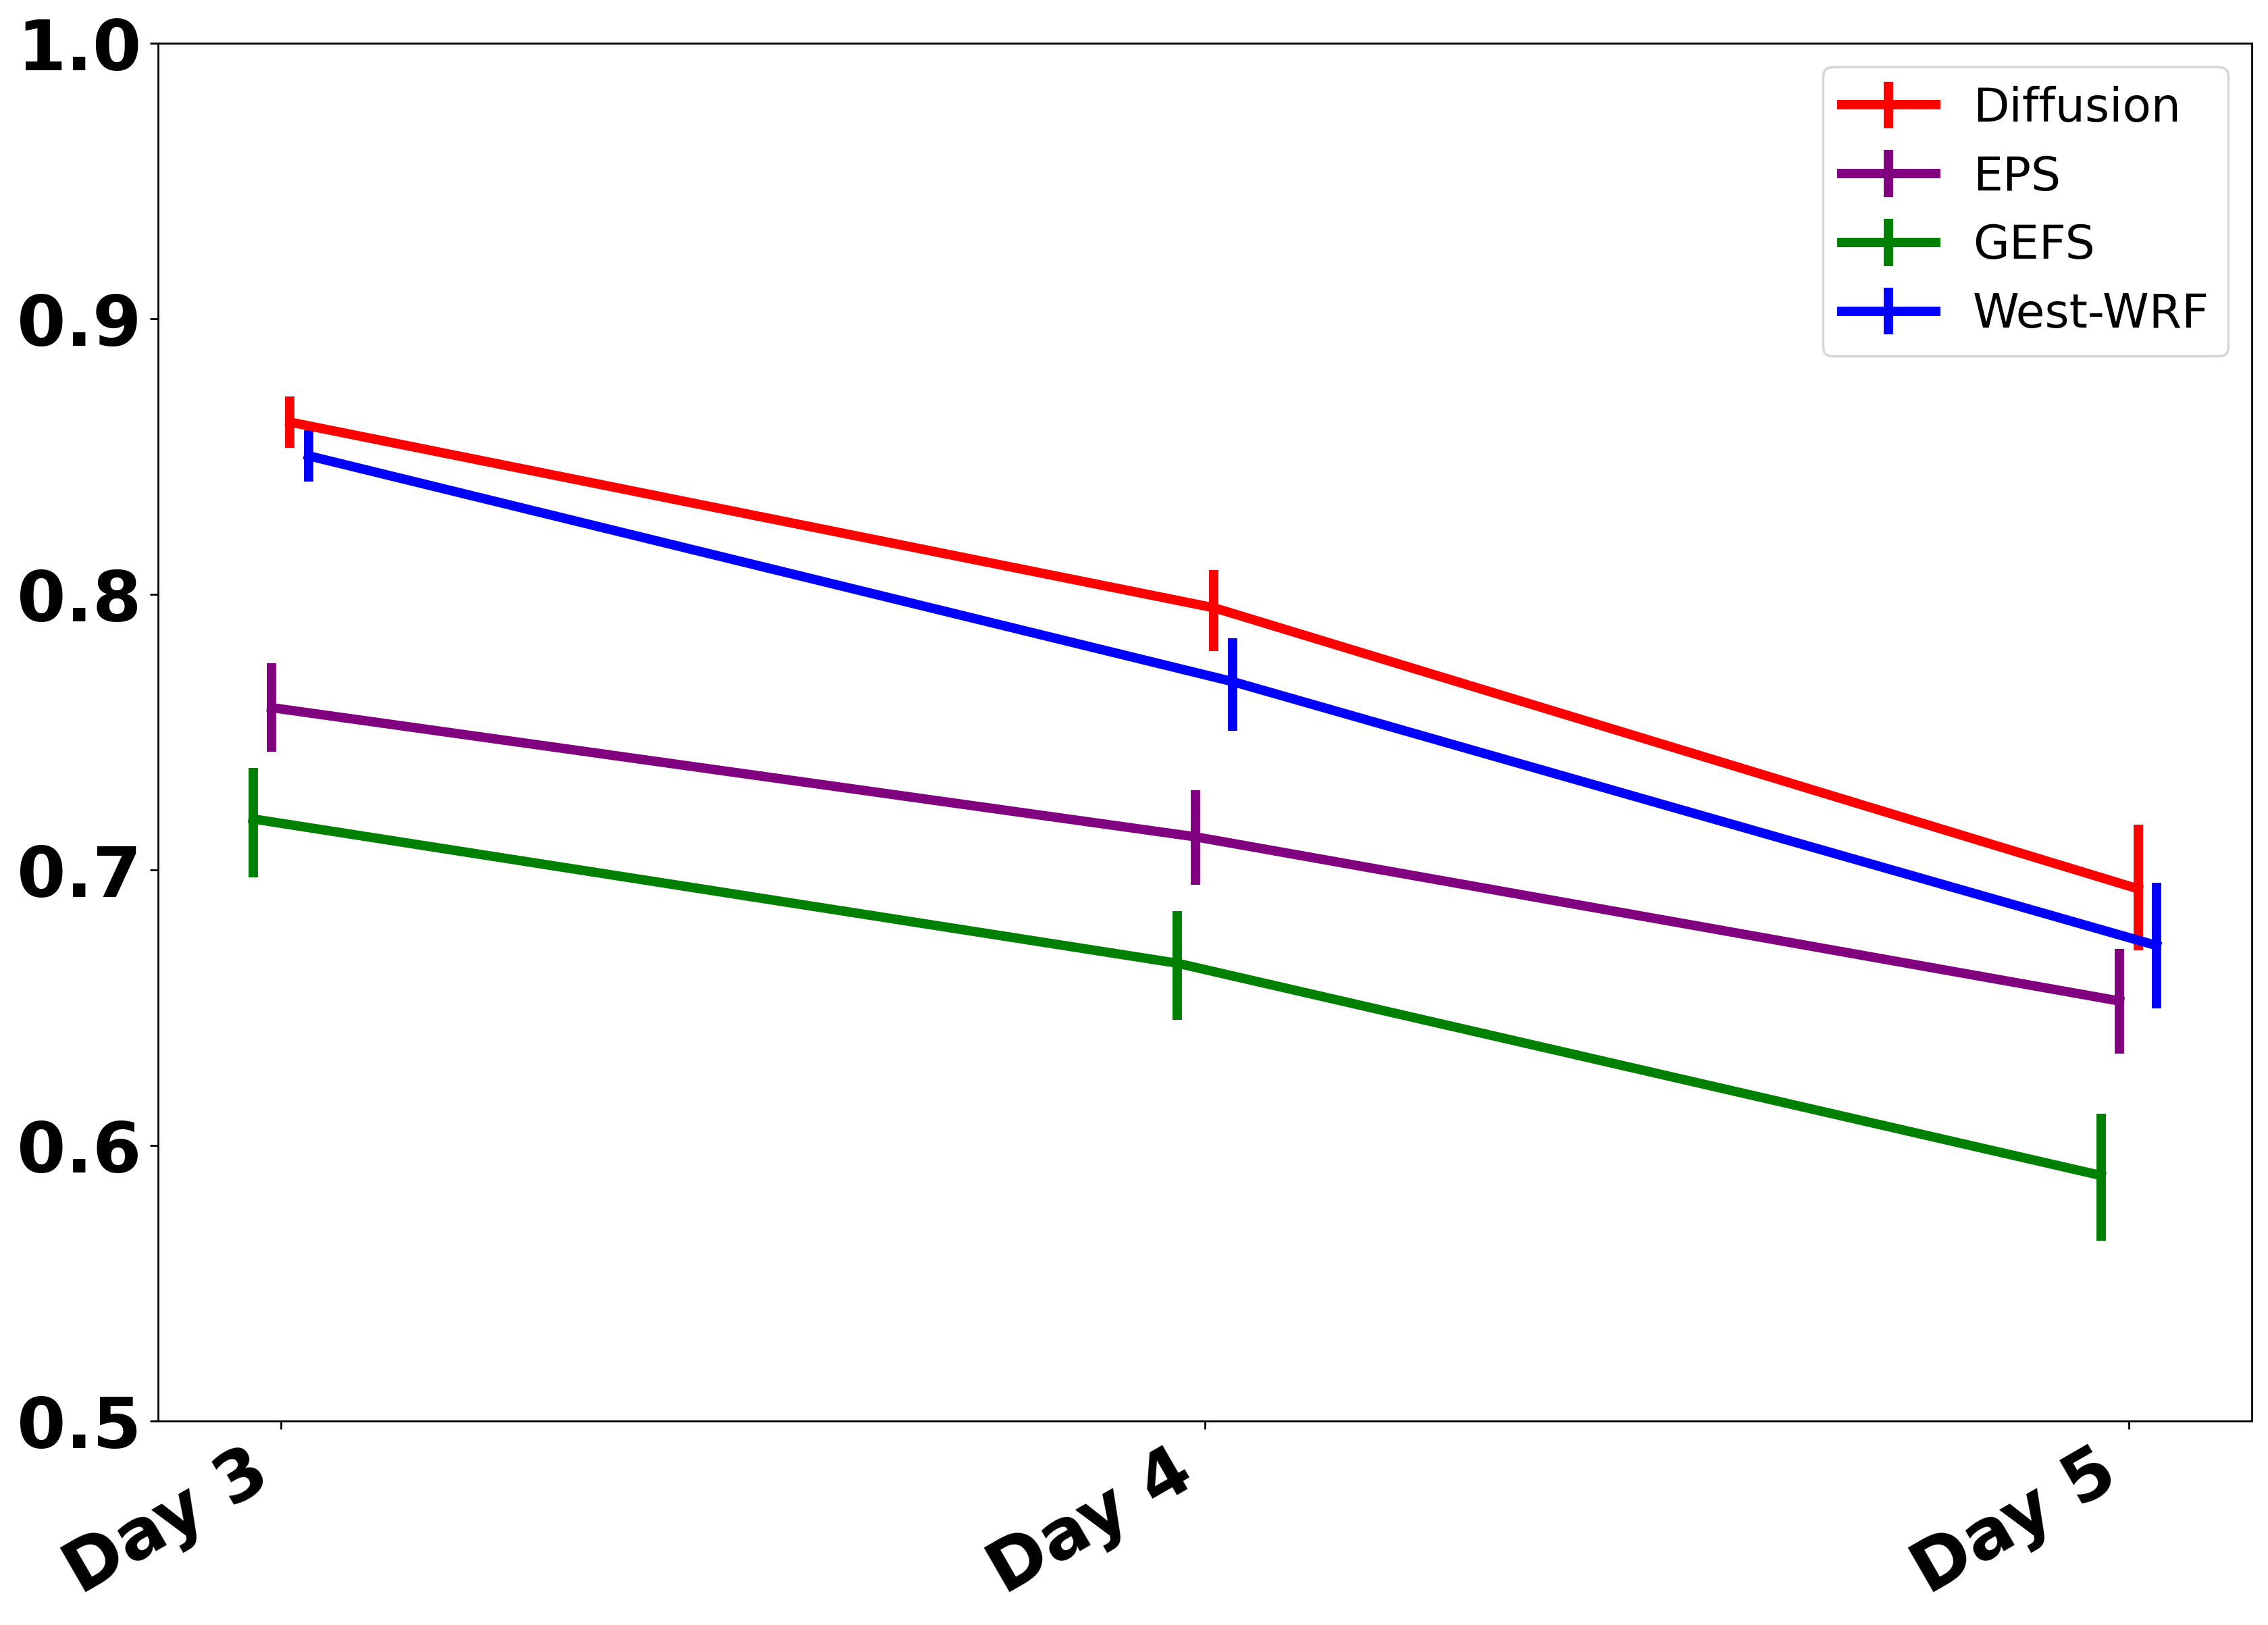

In [33]:
#ACC
figure(num=None, figsize=(16, 12), dpi=250, facecolor='w', edgecolor='k')


x = np.arange(3)
#plt.plot(x, WRF, color='blue',linewidth=3)
#plt.plot(x, Diffusion, color='red',linewidth=3);

plt.errorbar(x+0.01,DiffusionACC,np.abs(DiffusionACC-Diffusionerrorbars),color='red',label='Diffusion',linewidth = 4)
plt.errorbar(x-0.01,ecACC,np.abs(ecACC-ecerrorbars),color='purple',label='EPS',linewidth = 4)
plt.errorbar(x-0.03,gefsACC,np.abs(gefsACC-gefserrorbars),color='green',label='GEFS',linewidth = 4)

plt.errorbar(x+0.03,WRFACC,np.abs(WRFACC - WRFerrorbars),color='blue',label='West-WRF',linewidth = 4)


#plt.xlim(0,9)
plt.gcf().autofmt_xdate()
plt.legend(prop={'size': 20})
plt.yticks(weight='bold',size = 30)
plt.xticks(weight='bold',ticks = [0,1,2],labels=['Day 3','Day 4','Day 5'],size = 30)
plt.ylim([.5,1])


(40.0, 100.0)

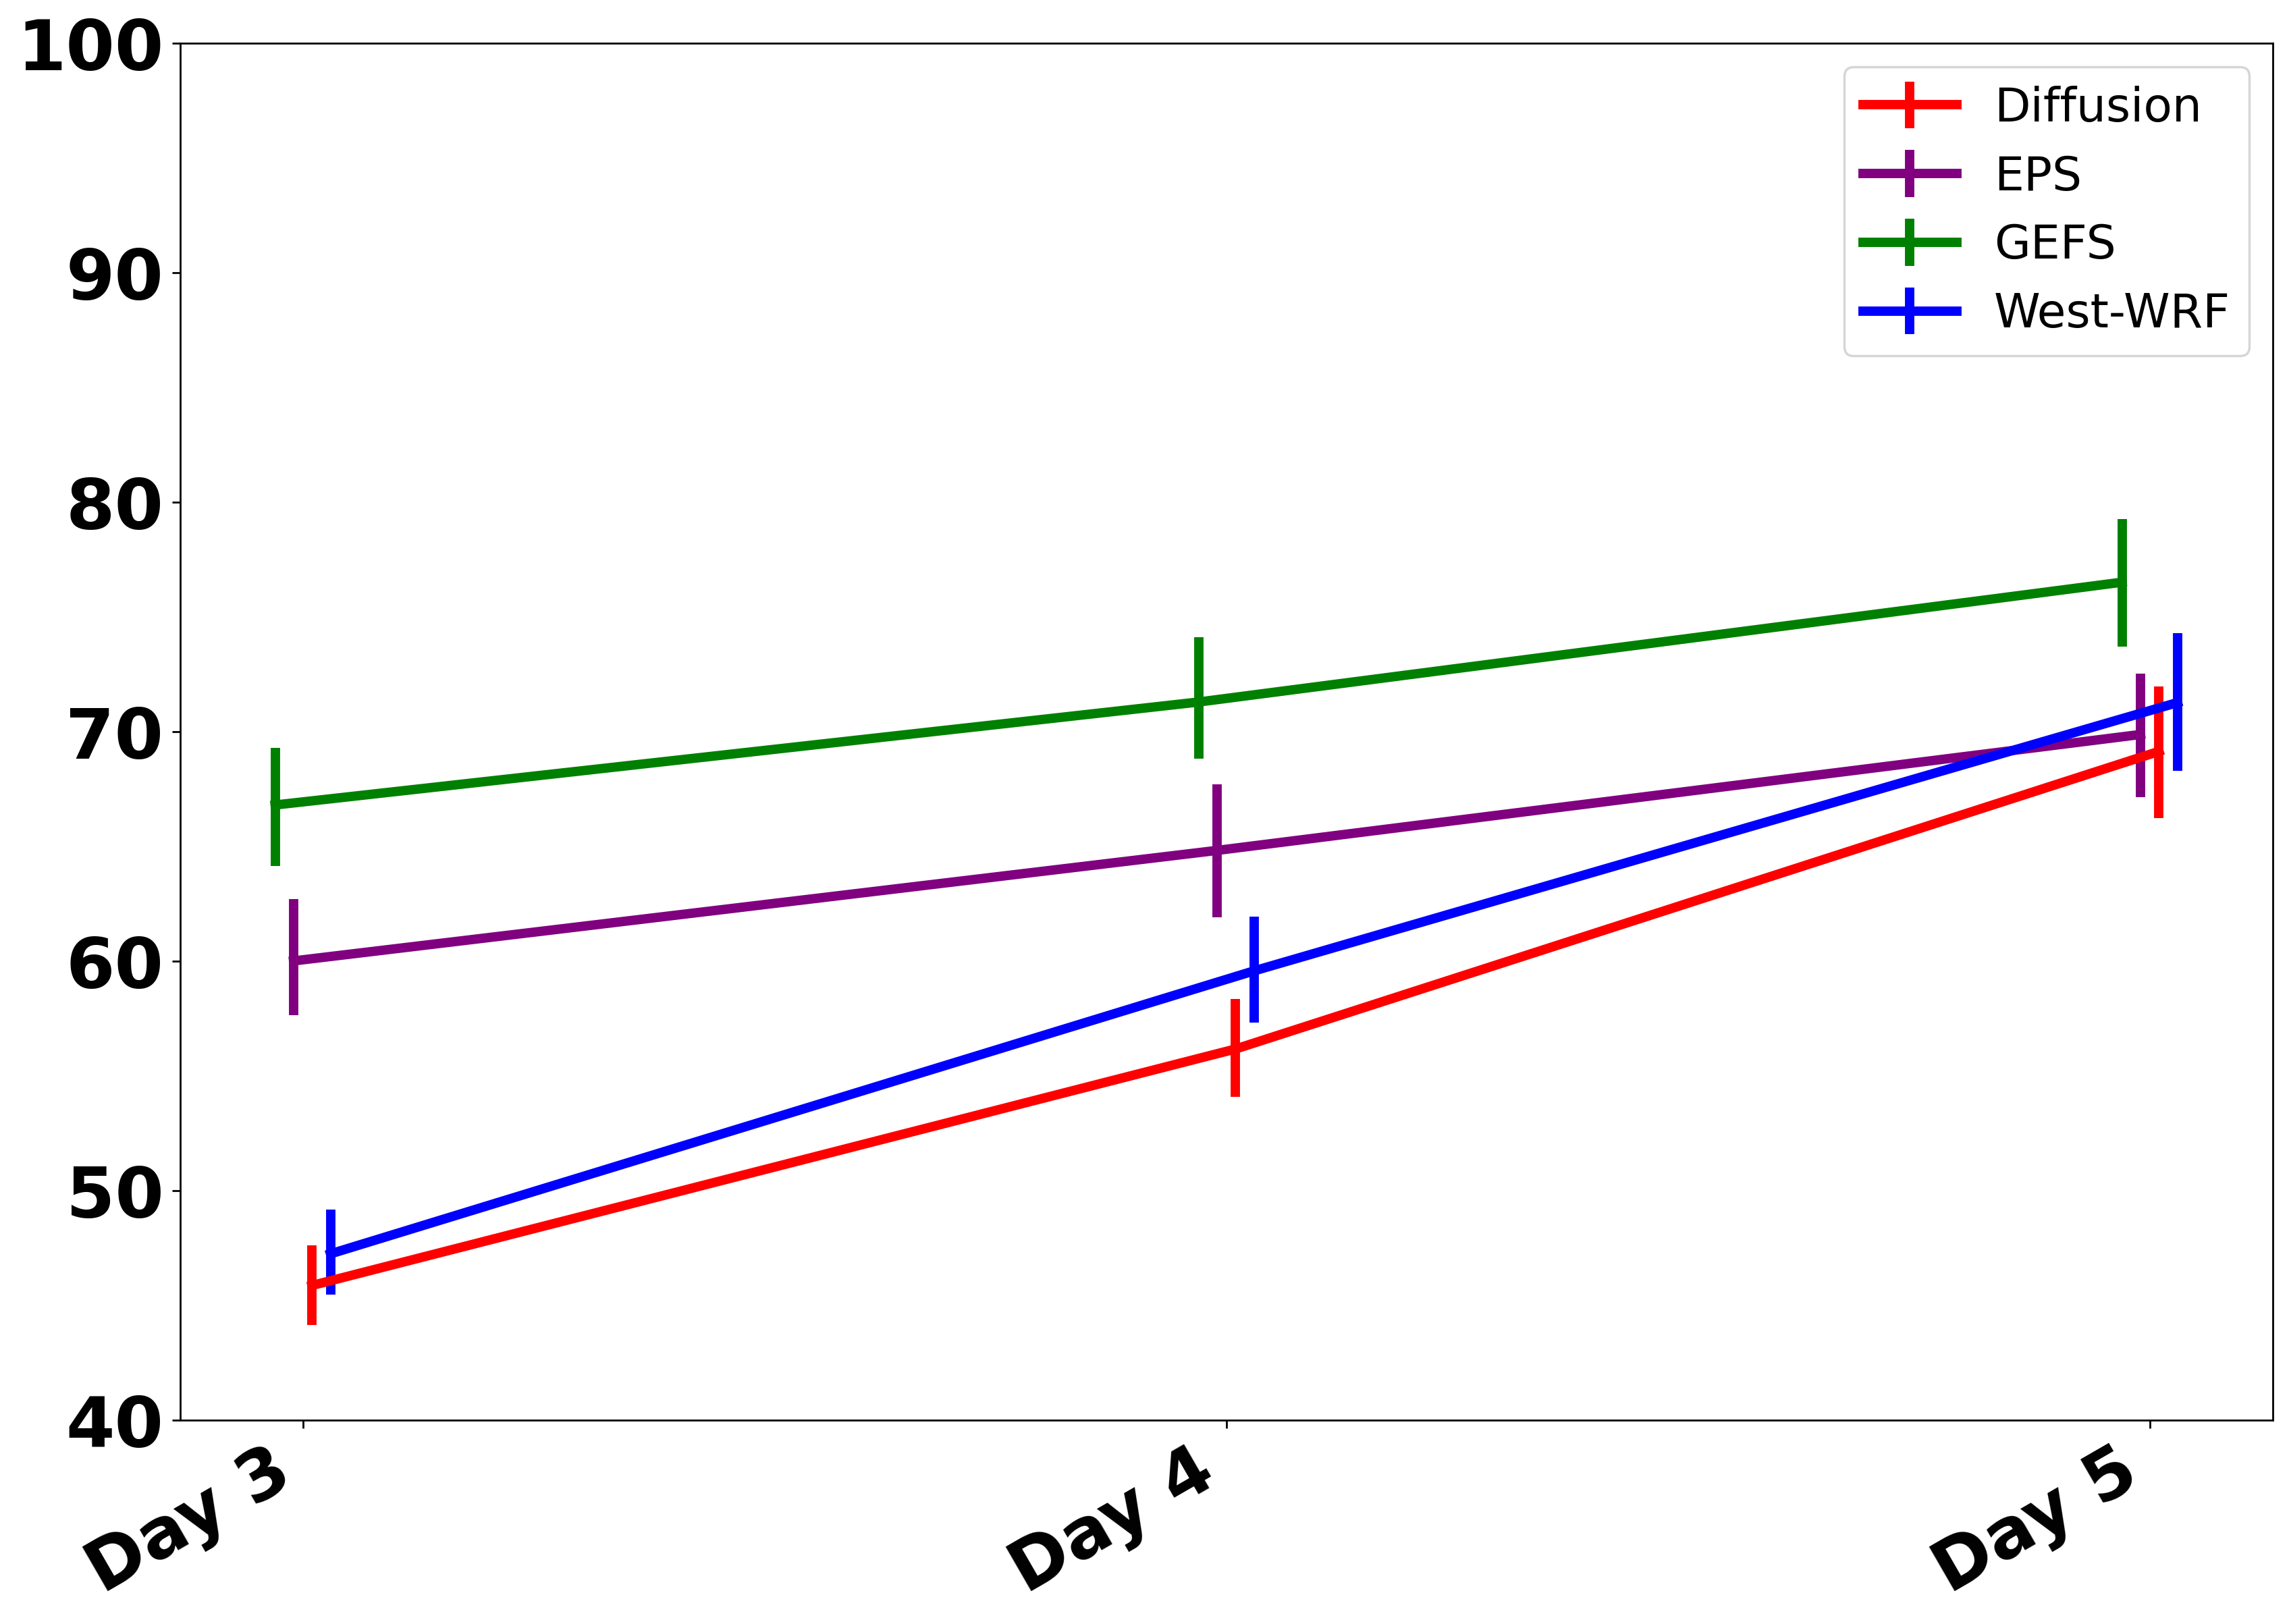

In [29]:
#RMSE
figure(num=None, figsize=(16, 12), dpi=250, facecolor='w', edgecolor='k')


x = np.arange(3)

plt.errorbar(x+0.01,DiffusionRMSE,np.abs(DiffusionRMSE-Diffusionerrorbars),color='red',label='Diffusion',linewidth = 4)
plt.errorbar(x-0.01,ecRMSE,np.abs(ecRMSE-ecerrorbars),color='purple',label='EPS',linewidth = 4)
plt.errorbar(x-0.03,gefsRMSE,np.abs(gefsRMSE-gefserrorbars),color='green',label='GEFS',linewidth = 4)

plt.errorbar(x+0.03,WRFRMSE,np.abs(WRFRMSE - WRFerrorbars),color='blue',label='West-WRF',linewidth = 4)


#plt.xlim(0,9)
plt.gcf().autofmt_xdate()
plt.legend(prop={'size': 20})
plt.yticks(weight='bold',size = 30)
plt.xticks(weight='bold',ticks = [0,1,2],labels=['Day 3','Day 4','Day 5'],size = 30)
plt.ylim([40,100])



In [38]:
Diffusionerrorbars = np.zeros([2,3])
WRFerrorbars = np.zeros([2,3])
i = 0

Diffusionerrorbars[0,0] = WRFRMSE[0]-np.percentile(P_BootstrapDiffusionRMSEday3[:],2.5)
Diffusionerrorbars[1,0] = WRFRMSE[0]-np.percentile(P_BootstrapDiffusionRMSEday3[:],97.5)
WRFerrorbars[0,0] = DiffusionRMSE[0]+np.percentile(P_BootstrapDiffusionRMSEday3[:],97.5)
WRFerrorbars[1,0] = DiffusionRMSE[0]+np.percentile(P_BootstrapDiffusionRMSEday3[:],2.5)

Diffusionerrorbars[0,1] = WRFRMSE[1]-np.percentile(P_BootstrapDiffusionRMSEday4[:],2.5)
Diffusionerrorbars[1,1] = WRFRMSE[1]-np.percentile(P_BootstrapDiffusionRMSEday4[:],97.5)
WRFerrorbars[0,1] = DiffusionRMSE[1]+np.percentile(P_BootstrapDiffusionRMSEday4[:],97.5)
WRFerrorbars[1,1] = DiffusionRMSE[1]+np.percentile(P_BootstrapDiffusionRMSEday4[:],2.5)

Diffusionerrorbars[0,2] = WRFRMSE[2]-np.percentile(P_BootstrapDiffusionRMSEday5[:],2.5)
Diffusionerrorbars[1,2] = WRFRMSE[2]-np.percentile(P_BootstrapDiffusionRMSEday5[:],97.5)
WRFerrorbars[0,2] = DiffusionRMSE[2]+np.percentile(P_BootstrapDiffusionRMSEday5[:],97.5)
WRFerrorbars[1,2] = DiffusionRMSE[2]+np.percentile(P_BootstrapDiffusionRMSEday5[:],2.5)
Diffusionerr = Diffusionerrorbars[0,:]-Diffusionerrorbars[1,:]
WRFerr = WRFerrorbars[0,:]-WRFerrorbars[1,:]

In [22]:
diff_mean1 = diff1.mean(dim='member').assign_coords(lat = era1.lat, lon = era1.lon)
ACCdiff1 = climpred.metrics._pearson_r(diff_mean1,era1,dim=["time"])
ACCWRF1 = climpred.metrics._pearson_r(dataX1,era1,dim=["time"])
diff_mean2 = diff2.mean(dim='member').assign_coords(lat = era1.lat, lon = era1.lon)
ACCdiff2 = climpred.metrics._pearson_r(diff_mean2,era2,dim=["time"])
ACCWRF2 = climpred.metrics._pearson_r(dataX2,era2,dim=["time"])
diff_mean3 = diff3.mean(dim='member').assign_coords(lat = era1.lat, lon = era1.lon)
ACCdiff3 = climpred.metrics._pearson_r(diff_mean3,era3,dim=["time"])
ACCWRF3 = climpred.metrics._pearson_r(dataX3,era3,dim=["time"])

<ipython-input-23-cbeabc270f00>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('bwr')
<ipython-input-23-cbeabc270f00>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = Dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/preprocessed/lead_0/train/F000_WY_1985_500mb.nc').variables['lat'][13:]
<ipython-input-23-cbeabc270f00>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doi

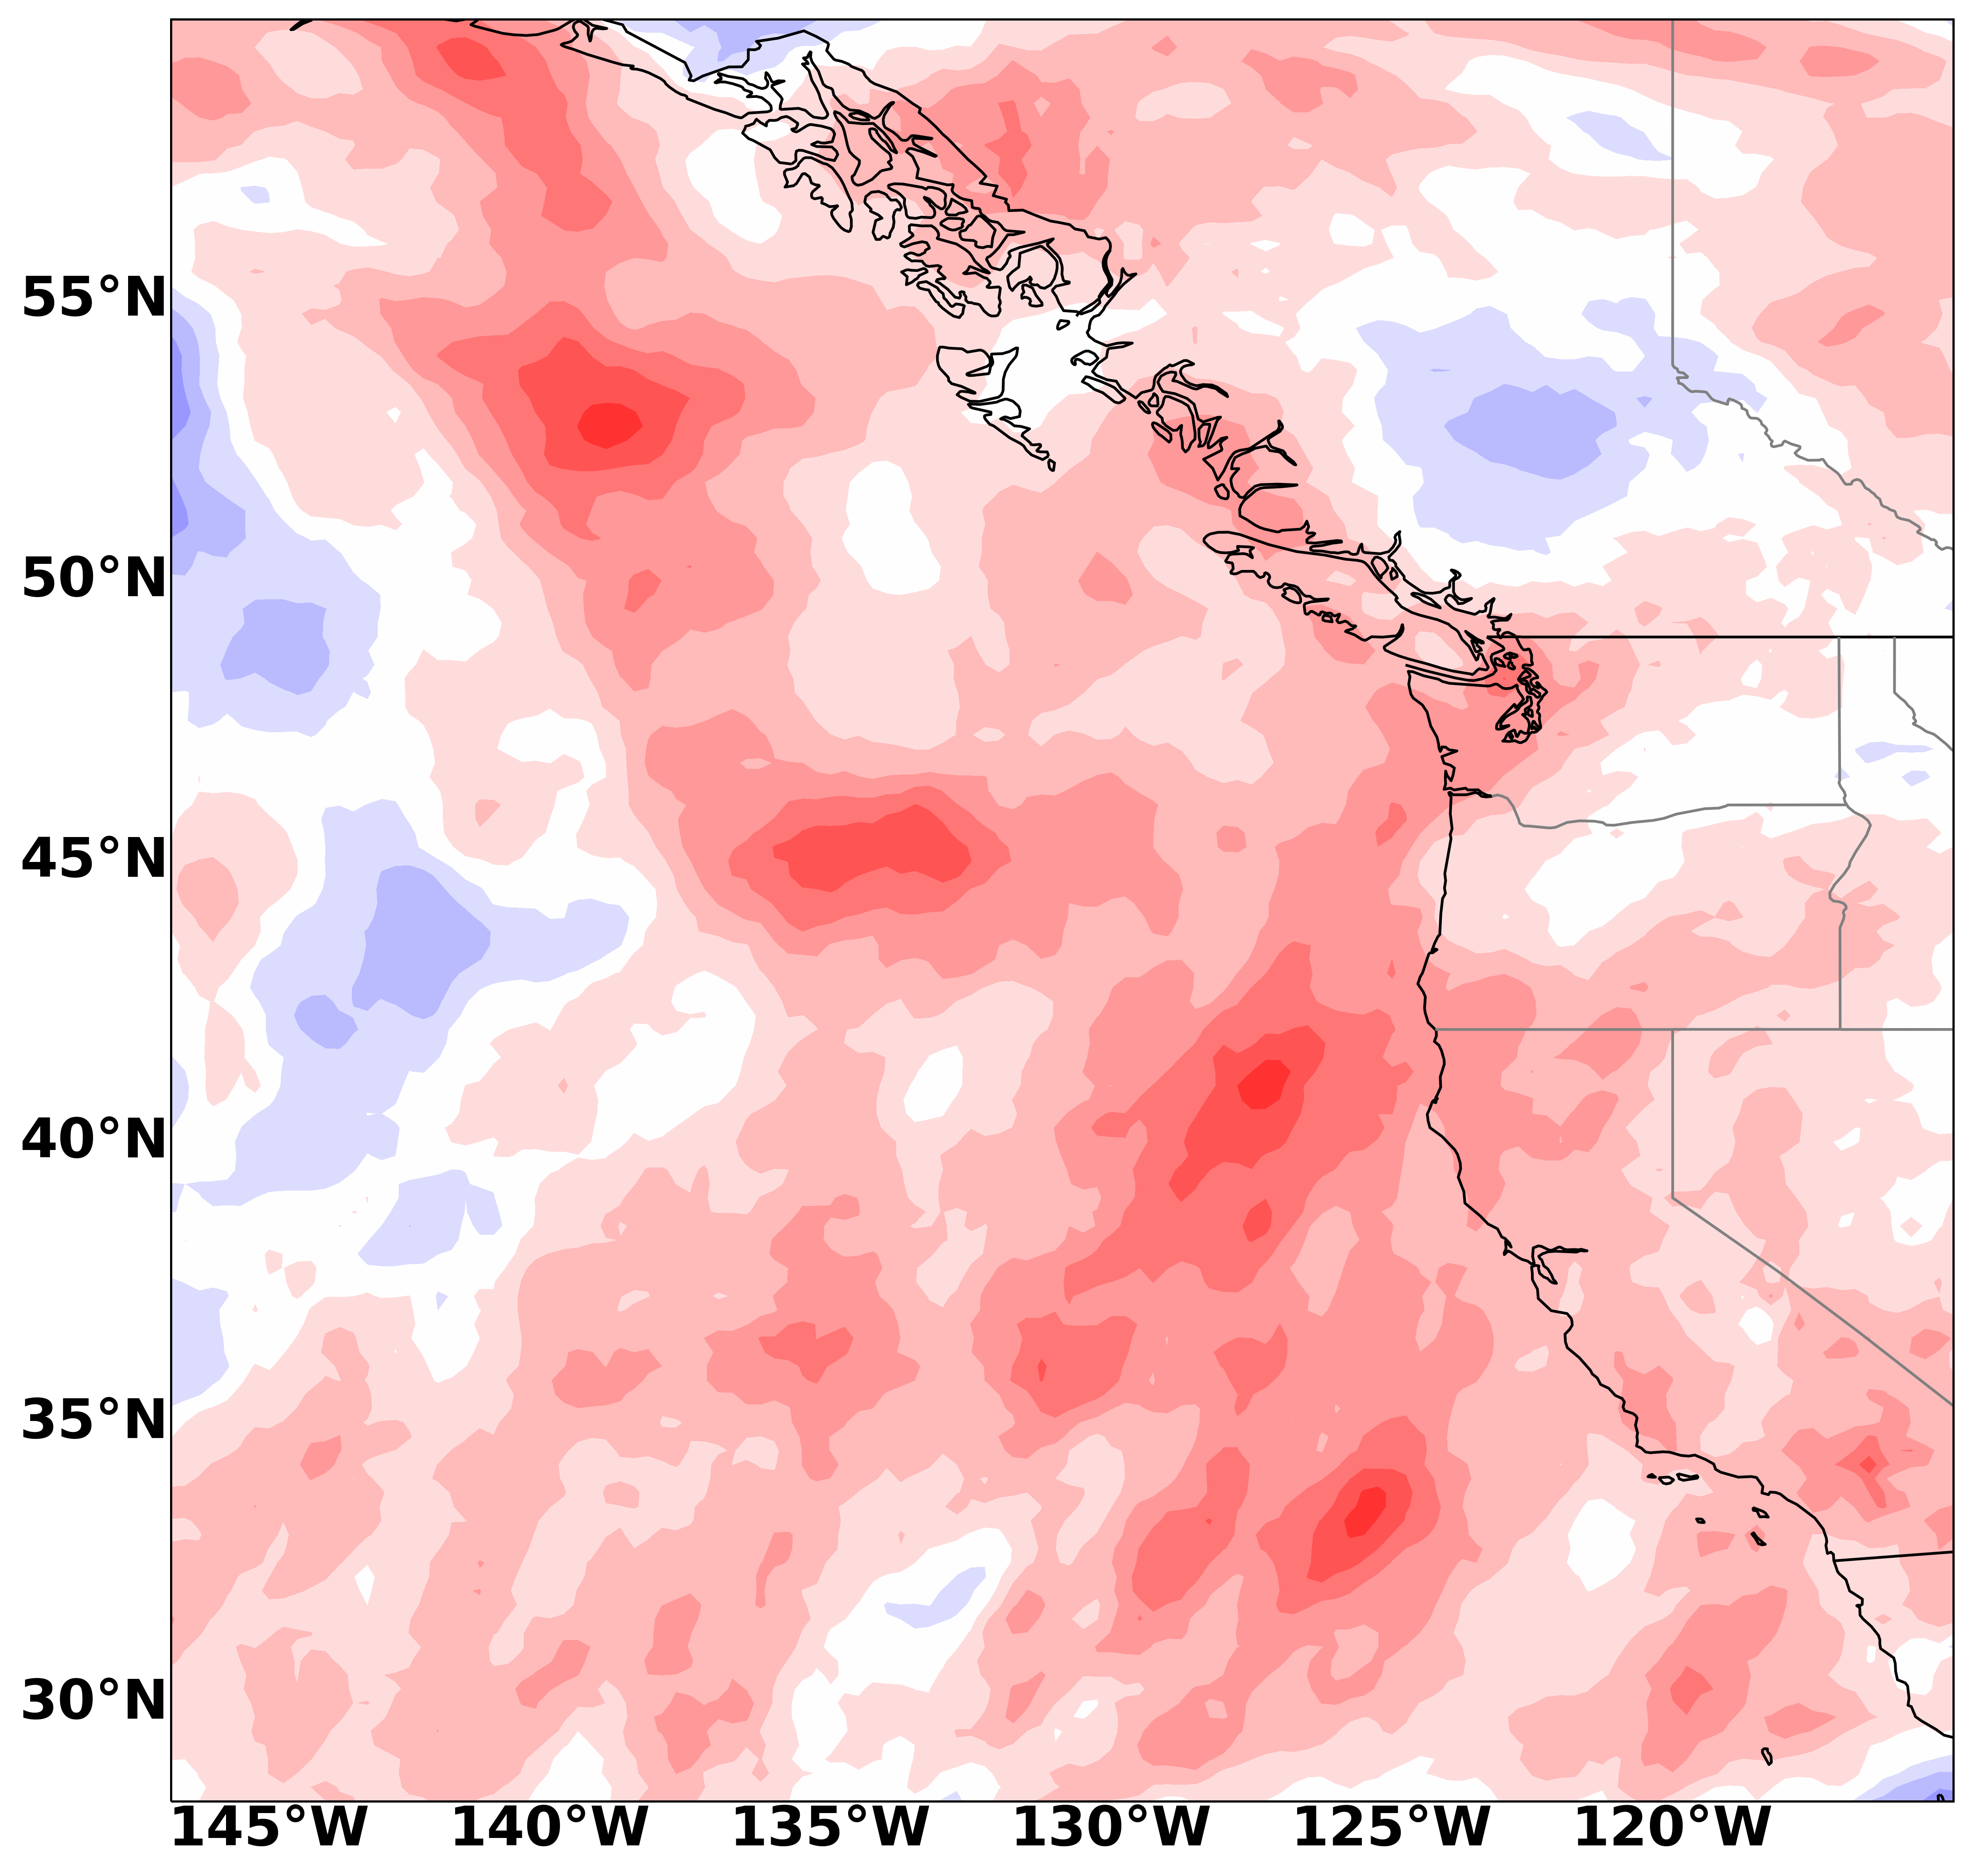

In [23]:
conlevels = np.linspace(-.1,.1,num=16) #adjust contours 

colormap = plt.cm.get_cmap('bwr') 

figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude= -102.5,globe=None))
ax._autoscaleXon = False
ax._autoscaleYon = False
lat = Dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/preprocessed/lead_0/train/F000_WY_1985_500mb.nc').variables['lat'][13:]
lon = Dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/preprocessed/lead_0/train/F000_WY_1985_500mb.nc').variables['lon'][13:]

ACCdiff = (ACCdiff1+ACCdiff2+ACCdiff3)/3
ACCWRF = (ACCWRF1+ACCWRF2+ACCWRF3)/3
x = np.array(ACCdiff)-np.array(ACCWRF)
plt.contourf(lon,lat,x,conlevels,
			transform=ccrs.PlateCarree(),extend = 'both', cmap = colormap)


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
		scale='50m',
		facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(states_provinces, edgecolor='gray')

#cbar = plt.colorbar(orientation='horizontal',ticks=[-20,-12,-4,4,12,20])
#cbar.ax.set_xlabel('RMSE Difference [kg $m^-1$ $s^-1$] (WRF - Diffusion)', rotation=0, fontsize = 25, weight='bold')
#cbar.ax.tick_params(labelsize=20)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				  linewidth=0, color='gray', alpha=0.5)
gl.xlabel_style = {'size': 20, 'weight': 'bold'}
gl.ylabel_style = {'size': 20, 'weight': 'bold'}
gl.xlabels_top = False
gl.ylabels_right = False
#plt.title('Diffusion',weight='bold',size=24)